In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import re
import time
import math
import itertools
from collections import Counter
import gudhi # For Gromov-Hausdorff computation
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize
import os
import torch
from torch import nn
import faiss
from scipy.stats import pearsonr
import pingouin as pg # For running statistical tests
from laserembeddings import Laser # LASER sentence embedding model

# I load the SentenceTransformer package from a different directory than my home directory
# because one of the embedding models that I use (LaBSE) is quite large
os.chdir('REDACTED FOR ANONYMITY')
from sentence_transformers import SentenceTransformer, util # LaBSE sentence embedding model

/usr2/collab/agjones/.local/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.0, the latest is 0.2.1.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs
/usr2/collab/agjones/.local/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.3.10, the latest is 0.3.11.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


### Connecting to GPU

In [ ]:
# Checks for GPU
if torch.cuda.is_available():
    print('Using GPU: {}'.format(torch.cuda.get_device_name(0)))
    device = torch.device('cuda')
else:
    print('Using CPU')
    device = torch.device('cpu')

Using CPU


I don't have enough space in my home directory, so I have to download the LaBSE model (it's 1.75GB!) to another directory.

In [ ]:
# Change Torch home directory . . .
os.environ['TORCH_HOME'] = 'REDACTED FOR ANONYMITY'

In [ ]:
# . . . confirm directory has changed
from torch.hub import _get_torch_home
torch_cache_home = _get_torch_home()
print(torch_cache_home)

### Initializing LaBSE embedding model

In [ ]:
# Loading LaBSE sentence embedding model
labse_model = SentenceTransformer('LaBSE')
labse_model.cuda() # puts model on GPU; you should also be able to pass this as a parameter to the above command

SentenceTransformer(
  (0): Transformer(
    (auto_model): BertModel(
      (embeddings): BertEmbeddings(
        (word_embeddings): Embedding(501153, 768, padding_idx=0)
        (position_embeddings): Embedding(512, 768)
        (token_type_embeddings): Embedding(2, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): BertEncoder(
        (layer): ModuleList(
          (0): BertLayer(
            (attention): BertAttention(
              (self): BertSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.1, inplace=False)
              )
              (output): BertSelfOutput(
                (dense): Linear(in_features=768, out_features=768, bias=True)
      

### Initializing LASER embedding model

In [ ]:
# # Only run this if you haven't already downloaded the LASER models
# !python -m laserembeddings download-models

In [ ]:
# Loading LASER sentence embedding model
# Unlike laBSE, LASER will automatically use GPU so long as one is available
# and accessible to PyTorch
laser_model = Laser()
if torch.cuda.is_available():
    print('Using GPU for LASER embeddings')
else:
    print('Using CPU for LASER embeddings')

Using GPU for LASER embeddings


### Reading in the aligned Bible texts

We'll use two books from the New Testament, each verse-aligned across 101 languages (which gives ${101 \choose 2} = 5050$ unordered alignments; recall that ${n \choose 2} = \frac{n!}{2!(n-2)!} = \frac{n(n-1)}{2}$). We use only New Testament books simply because this part of the Bible is available in more languages in [the corpus we are using](http://christos-c.com/bible/). The books we use are Matthew and John, chosen arbitrarily (if you think there's a good reason why this choice shouldn't be arbitrary, please let me know!).

#### Book of Matthew

In [ ]:
# Changing directory to path where texts are stored
os.chdir('REDACTED FOR ANONYMITY')

In [ ]:
matt_texts = []
for filename in os.listdir(os.getcwd()):
    path_to_file = os.path.join(os.getcwd(), filename)
    with open(path_to_file, 'r') as f:
        txt = f.read().splitlines()
        if len(txt)>0:
            matt_texts.append(txt)

<AxesSubplot:ylabel='Count'>

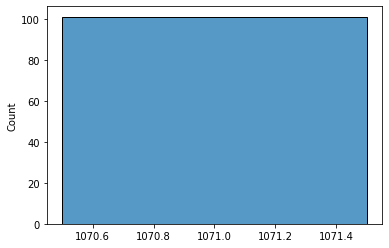

In [ ]:
# Quick way of checking that all the aligned texts are the same length!
matt_len = [len(t) for t in matt_texts]
sns.histplot(matt_len)

#### Book of John

In [ ]:
# Changing directory to path where texts are stored
os.chdir('REDACTED FOR ANONYMITY')

In [ ]:
john_texts = []
for filename in os.listdir(os.getcwd()):
    path_to_file = os.path.join(os.getcwd(), filename)
    with open(path_to_file, 'r') as f:
        txt = f.read().splitlines()
        if len(txt)>0:
            john_texts.append(txt)

<AxesSubplot:ylabel='Count'>

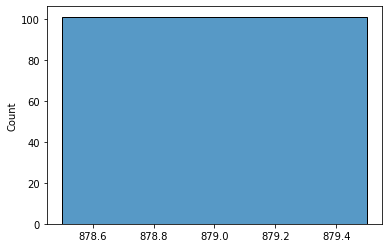

In [ ]:
# Quick way of checking that all the aligned texts are the same length!
john_len = [len(t) for t in john_texts]
sns.histplot(john_len)

In [ ]:
# Check that both books are aligned across the same number of languages
len(john_texts)==len(matt_texts)

True

In [ ]:
print('Number of languages aligned: {}'.format(len(john_texts)))

Number of languages aligned: 101


### Plotting some meta-data about the alignments

In [ ]:
matt_avg_sent_len = [np.average([len(s.split()) for s in t]) for t in matt_texts]
john_avg_sent_len = [np.average([len(s.split()) for s in t]) for t in john_texts]

<AxesSubplot:xlabel='Average sentence length', ylabel='Frequency'>

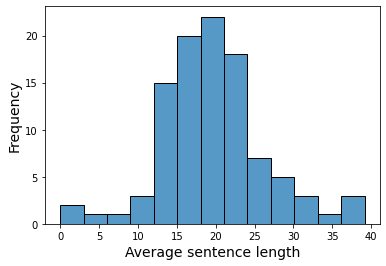

In [ ]:
plt.xlabel('Average sentence length', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
# The average sentence lengths in Matthew are pretty normally distributed
sns.histplot(matt_avg_sent_len)

<AxesSubplot:xlabel='Average sentence length', ylabel='Frequency'>

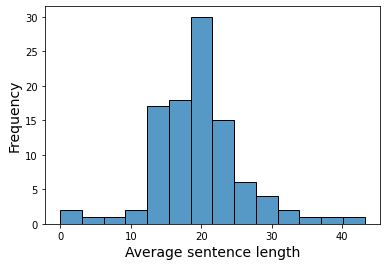

In [ ]:
plt.xlabel('Average sentence length', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
# The average sentence lengths are also pretty normally distributed, with thinner tails than Matthew
sns.histplot(john_avg_sent_len)

So it looks like there's a decent amount of variance in the average sentence lengths within the aligned texts, although some of this is no doubt due to the nature of the different languages' writing systems themselves. Still, this is an important independent variable to consider in our analysis. At least the *number of sentences* is controlled for, as well as the *domain*!

### Creating dictionaries of bitexts

#### Generating all possible (unordered) language pairings

In [ ]:
# Remember that we're still in the directory containing the Book of John texts!
for filename in os.listdir(os.getcwd()):
    print(filename)

Galela-NT.txt
Cakchiquel-NT.txt
Bulgarian.txt
Latin.txt
Arabic.txt
Finnish.txt
Ukranian-NT.txt
Uspanteco-NT.txt
Ojibwa-NT.txt
Aguaruna-NT.txt
Nepali.txt
Marathi.txt
Lukpa-NT.txt
Turkish.txt
Farsi.txt
Paite.txt
Hindi.txt
Cherokee-NT.txt
K'iche'-NT-SIL.txt
Uma-NT.txt
Russian.txt
Syriac-NT.txt
Xhosa.txt
English-WEB.txt
K'iche'-NT.txt
Thai.txt
Campa-NT.txt
Q'eqchi'.txt
Tagalog.txt
Barasana-NT.txt
Nahuatl-NT.txt
Portuguese.txt
Zarma.txt
Korean.txt
Coptic-NT.txt
Hungarian.txt
Shona.txt
Cebuano.txt
Ewe-NT.txt
Norwegian.txt
Vietnamese-tok.txt
Wolaytta-NT.txt
Kannada.txt
Dinka-NT.txt
Indonesian.txt
English.txt
Myanmar.txt
Jakalteko-NT.txt
Slovene.txt
Greek.txt
Chinantec-NT.txt
Icelandic.txt
Polish.txt
Romani-NT.txt
Maori.txt
Cabecar-NT.txt
Mam-NT.txt
Latvian-NT.txt
Chinese.txt
Japanese-tok.txt
Albanian.txt
Basque-NT.txt
Esperanto.txt
Gujarati-NT.txt
Serbian.txt
Vietnamese.txt
German.txt
Telugu.txt
Creole.txt
Quichua-NT.txt
Achuar-NT.txt
Malagasy.txt
Camsa-NT.txt
Swedish.txt
Aukan-NT.txt
Japanes

In [ ]:
# Generate the list of languages
langs = [f.replace('.txt', '').replace('-NT', '') for f in os.listdir(os.getcwd())]

#### Constructing the dictionary of bitexts for each book

In [ ]:
matt_bitexts, john_bitexts = {}, {}
for matt_pair, john_pair, lang_pair in zip(itertools.combinations(matt_texts, 2), 
                                           itertools.combinations(john_texts, 2),
                                           itertools.combinations(langs, 2)):
    
        key = '{}-{}'.format(lang_pair[0], lang_pair[1])
        matt_value = [matt_pair[0], matt_pair[1]]
        john_value = [john_pair[0], john_pair[1]]
        matt_bitexts[key] = matt_value
        john_bitexts[key] = john_value
        
assert len(matt_bitexts)==5050, len(matt_bitexts)==len(john_bitexts)

### Generating sentence embeddings for all texts

#### Generating LaBSE embeddings

If the cell below is commented out, it's only because I don't want to accidentally run it again once the sentence embeddings have been generated (the embedding process takes a little while).

In [ ]:
matt_embs_labse = [labse_model.encode(text) for text in tqdm(matt_texts)] # Book of Matthew embeddings
john_embs_labse = [labse_model.encode(text) for text in tqdm(john_texts)] # Book of John embeddings

100%|██████████| 101/101 [01:22<00:00,  1.23it/s]


In [ ]:
print(len(matt_embs_labse)) # should be 101
print(matt_embs_labse[0].shape) # should be (1071, 768) -> 1071 sentences, emb_dim=1071
print(john_embs_labse[0].shape) # should be (879, 768) -> 879 sentences, emb_dim=768
print(len(john_embs_labse)==len(matt_embs_labse)) # check for equality

101
(1071, 768)
(879, 768)
True


As can be seen from the above print statements, both *matt_embs* and *john_embs* can be thought of as tensors (despite the fact that they're actually Python lists) of shape $(p, q, r)$, where $p$ is the number of languages in the aligned corpora, $q$ is the number of sentences in each text within the corpora, and $r$ is the embedding dimension, namely $768$ for LaBSE (and $1024$ for LASER).

#### Generating LASER embeddings

A nice ISO 639-1 lookup from [here.](https://gist.github.com/Josantonius/b455e315bc7f790d14b136d61d9ae469)

In [ ]:
iso_codes ={       
        "aa":    "Afar",
        "ab":    "Abkhazian",
        "af":    "Afrikaans",
        "am":    "Amharic",
        "ar":    "Arabic",
        "ar-ae": "Arabic (U.A.E.)",
        "ar-bh": "Arabic (Bahrain)",
        "ar-dz": "Arabic (Algeria)",
        "ar-eg": "Arabic (Egypt)",
        "ar-iq": "Arabic (Iraq)",
        "ar-jo": "Arabic (Jordan)",
        "ar-kw": "Arabic (Kuwait)",
        "ar-lb": "Arabic (Lebanon)",
        "ar-ly": "Arabic (Libya)",
        "ar-ma": "Arabic (Morocco)",
        "ar-om": "Arabic (Oman)",
        "ar-qa": "Arabic (Qatar)",
        "ar-sa": "Arabic (Saudi Arabia)",
        "ar-sy": "Arabic (Syria)",
        "ar-tn": "Arabic (Tunisia)",
        "ar-ye": "Arabic (Yemen)",
        "as":    "Assamese",
        "ay":    "Aymara",
        "az":    "Azeri",
        "ba":    "Bashkir",
        "be":    "Belarusian",
        "bg":    "Bulgarian",
        "bh":    "Bihari",
        "bi":    "Bislama",
        "bn":    "Bengali",
        "bo":    "Tibetan",
        "br":    "Breton",
        "ca":    "Catalan",
        "co":    "Corsican",
        "cs":    "Czech",
        "cy":    "Welsh",
        "da":    "Danish",
        "de":    "German",
        "de-at": "German (Austria)",
        "de-ch": "German (Switzerland)",
        "de-li": "German (Liechtenstein)",
        "de-lu": "German (Luxembourg)",
        "div":   "Divehi",
        "dz":    "Bhutani",
        "el":    "Greek",
        "en":    "English",
        "en-au": "English (Australia)",
        "en-bz": "English (Belize)",
        "en-ca": "English (Canada)",
        "en-gb": "English (United Kingdom)",
        "en-ie": "English (Ireland)",
        "en-jm": "English (Jamaica)",
        "en-nz": "English (New Zealand)",
        "en-ph": "English (Philippines)",
        "en-tt": "English (Trinidad)",
        "en-us": "English (United States)",
        "en-za": "English (South Africa)",
        "en-zw": "English (Zimbabwe)",
        "eo":    "Esperanto",
        "es":    "Spanish",
        "es-ar": "Spanish (Argentina)",
        "es-bo": "Spanish (Bolivia)",
        "es-cl": "Spanish (Chile)",
        "es-co": "Spanish (Colombia)",
        "es-cr": "Spanish (Costa Rica)",
        "es-do": "Spanish (Dominican Republic)",
        "es-ec": "Spanish (Ecuador)",
        "es-es": "Spanish (España)",
        "es-gt": "Spanish (Guatemala)",
        "es-hn": "Spanish (Honduras)",
        "es-mx": "Spanish (Mexico)",
        "es-ni": "Spanish (Nicaragua)",
        "es-pa": "Spanish (Panama)",
        "es-pe": "Spanish (Peru)",
        "es-pr": "Spanish (Puerto Rico)",
        "es-py": "Spanish (Paraguay)",
        "es-sv": "Spanish (El Salvador)",
        "es-us": "Spanish (United States)",
        "es-uy": "Spanish (Uruguay)",
        "es-ve": "Spanish (Venezuela)",
        "et":    "Estonian",
        "eu":    "Basque",
        "fa":    "Farsi",
        "fi":    "Finnish",
        "fj":    "Fiji",
        "fo":    "Faeroese",
        "fr":    "French",
        "fr-be": "French (Belgium)",
        "fr-ca": "French (Canada)",
        "fr-ch": "French (Switzerland)",
        "fr-lu": "French (Luxembourg)",
        "fr-mc": "French (Monaco)",
        "fy":    "Frisian",
        "ga":    "Irish",
        "gd":    "Gaelic",
        "gl":    "Galician",
        "gn":    "Guarani",
        "gu":    "Gujarati",
        "ha":    "Hausa",
        "he":    "Hebrew",
        "hi":    "Hindi",
        "hr":    "Croatian",
        "hu":    "Hungarian",
        "hy":    "Armenian",
        "ia":    "Interlingua",
        "id":    "Indonesian",
        "ie":    "Interlingue",
        "ik":    "Inupiak",
        "in":    "Indonesian",
        "is":    "Icelandic",
        "it":    "Italian",
        "it-ch": "Italian (Switzerland)",
        "iw":    "Hebrew",
        "ja":    "Japanese",
        "ji":    "Yiddish",
        "jw":    "Javanese",
        "ka":    "Georgian",
        "kk":    "Kazakh",
        "kl":    "Greenlandic",
        "km":    "Cambodian",
        "kn":    "Kannada",
        "ko":    "Korean",
        "kok":   "Konkani",
        "ks":    "Kashmiri",
        "ku":    "Kurdish",
        "ky":    "Kirghiz",
        "kz":    "Kyrgyz",
        "la":    "Latin",
        "ln":    "Lingala",
        "lo":    "Laothian",
        "ls":    "Slovenian",
        "lt":    "Lithuanian",
        "lv":    "Latvian",
        "mg":    "Malagasy",
        "mi":    "Maori",
        "mk":    "FYRO Macedonian",
        "ml":    "Malayalam",
        "mn":    "Mongolian",
        "mo":    "Moldavian",
        "mr":    "Marathi",
        "ms":    "Malay",
        "mt":    "Maltese",
        "my":    "Burmese",
        "na":    "Nauru",
        "nb-no": "Norwegian (Bokmal)",
        "ne":    "Nepali (India)",
        "nl":    "Dutch",
        "nl-be": "Dutch (Belgium)",
        "nn-no": "Norwegian",
        "no":    "Norwegian (Bokmal)",
        "oc":    "Occitan",
        "om":    "(Afan)/Oromoor/Oriya",
        "or":    "Oriya",
        "pa":    "Punjabi",
        "pl":    "Polish",
        "ps":    "Pashto/Pushto",
        "pt":    "Portuguese",
        "pt-br": "Portuguese (Brazil)",
        "qu":    "Quechua",
        "rm":    "Rhaeto-Romanic",
        "rn":    "Kirundi",
        "ro":    "Romanian",
        "ro-md": "Romanian (Moldova)",
        "ru":    "Russian",
        "ru-md": "Russian (Moldova)",
        "rw":    "Kinyarwanda",
        "sa":    "Sanskrit",
        "sb":    "Sorbian",
        "sd":    "Sindhi",
        "sg":    "Sangro",
        "sh":    "Serbo-Croatian",
        "si":    "Singhalese",
        "sk":    "Slovak",
        "sl":    "Slovenian",
        "sm":    "Samoan",
        "sn":    "Shona",
        "so":    "Somali",
        "sq":    "Albanian",
        "sr":    "Serbian",
        "ss":    "Siswati",
        "st":    "Sesotho",
        "su":    "Sundanese",
        "sv":    "Swedish",
        "sv-fi": "Swedish (Finland)",
        "sw":    "Swahili",
        "sx":    "Sutu",
        "syr":    "Syriac",
        "ta":    "Tamil",
        "te":    "Telugu",
        "tg":    "Tajik",
        "th":    "Thai",
        "ti":    "Tigrinya",
        "tk":    "Turkmen",
        "tl":    "Tagalog",
        "tn":    "Tswana",
        "to":    "Tonga",
        "tr":    "Turkish",
        "ts":    "Tsonga",
        "tt":    "Tatar",
        "tw":    "Twi",
        "uk":    "Ukrainian",
        "ur":    "Urdu",
        "us":    "English",
        "uz":    "Uzbek",
        "vi":    "Vietnamese",
        "vo":    "Volapuk",
        "wo":    "Wolof",
        "xh":    "Xhosa",
        "yi":    "Yiddish",
        "yo":    "Yoruba",
        "zh":    "Chinese",
        "zh-cn": "Chinese (China)",
        "zh-hk": "Chinese (Hong Kong SAR)",
        "zh-mo": "Chinese (Macau SAR)",
        "zh-sg": "Chinese (Singapore)",
        "zh-tw": "Chinese (Taiwan)",
        "zu":    "Zulu"
}

In [ ]:
# Reverse the key-value relation of the dictionary
iso_639_1_dict = {iso_codes[k]:k for k in iso_codes}

In [ ]:
iso_for_bitexts = [iso_639_1_dict[lang] if lang in iso_639_1_dict else None for lang in langs]

LASER requires us to input a language ID (ISO 639-1 code) for tokenization purposes. If we have the language ID on hand, then we'll try entering it as a parameter to LASER. If not, or if LASER doesn't support that particular language for explicitly, we'll just embed using the generic (default) tokenizer LASER provides.

In [ ]:
# As with the above cell for generating embeddings, un-comment this and run it if you're starting with 
# a fresh kernel

matt_embs_laser, john_embs_laser = [], []
for i in tqdm(range(len(iso_for_bitexts))):
    lang_id = iso_for_bitexts[i]
    
    # If we have the language ID provided by the dictionary above . . .
    if lang_id is not None:
        # Try embedding using the language-specific tokenizer
        try:
            matt_emb = laser_model.embed_sentences(matt_texts[i], lang_id)
            john_emb = laser_model.embed_sentences(john_texts[i], lang_id)
        # But if that fails, use the generic tokenizer
        except:
            matt_emb = laser_model.embed_sentences(matt_texts[i], 'en')
            john_emb = laser_model.embed_sentences(john_texts[i], 'en')
            
    # Alternatively, if we don't have the language ID on hand, use the generic tokenizer
    else:
        matt_emb = laser_model.embed_sentences(matt_texts[i], 'en')
        john_emb = laser_model.embed_sentences(john_texts[i], 'en')
    
    # Either way, add the embeddings to the respective lists
    matt_embs_laser.append(matt_emb)
    john_embs_laser.append(john_emb)

100%|██████████| 101/101 [03:10<00:00,  1.89s/it]


In [ ]:
# See the analogous cell for the LaBSE embeddings for an explanation of the array dimensions
print(len(john_embs_laser))
print(john_embs_laser[0].shape)

101
(879, 1024)


That's it! We have all the embeddings we need for the task before us. In total, we have $101*(1071+879) = 196,950$ LaBSE sentence embeddings and the same number of LASER sentence embeddings, for a total of $393,900$ embeddings! Since the LaBSE embeddings are of dimension $d_{LaBSE} = 768$ and the LASER embeddings are of dimension $d_{LASER} = 1024$, we've generated a cross-lingual embedding "group" with $352,934,400$ floating-point elements! These embeddings, plus the models themselves, must be taking up a ton of space in local memory. Let's run !nvidia-smi and take a look.

In [ ]:
!nvidia-smi

Yep, we've used about **8 GiB** so far on a **16 GiB** GPU. That's a non-trivial chunk of memory, but since we won't be performing any further tasks that are nearly so memory-intensive, we should be fine for the rest of the experiments.

The most expensive and difficult part of the experiment computationally will be generating the **dependent variables** (DVs) (collecting some of the IVs will be incredibly tedious, but more so for the wetware than the hardware/software).

Each of the dependent variables will be primarily associated with each **language pair** in the bitexts from both of the Biblical books above (Matthew and John). However, it should be trivial to generate language-centric statistics from these results, e.g. computing the average F1-score for a given language across all the language pairs in which it appears. These are the dependent variables I plan on using for the time being:

1. **F1-score on the bitext retrieval task (F1)**. Given embeddings for aligned bitexts $\mathcal{X}, \mathcal{Y}$, this task consists of finding all parallel sentences between $\mathcal{X}$ and $\mathcal{Y}$. To this end, I will use **margin scoring** as described [here](https://www.aclweb.org/anthology/P19-1309.pdf). The implementation is straightforward with Facebook AI Similarity Search (FAISS), and I can copy-paste from notebooks from a previous project. I plan to use standard F1-score as the performance measure, i.e. $F = \frac{2PR}{P+R}$. 
2. **Average margin score**. Margin scoring is used to select optimal candidates in the bitext mining procedure described above. However, we can extract another continuous metric from this process by taking the average of the margin scores for each aligned pair of sentences, providing an additional intrinsic measure of alignment. The margin score between two sentence embeddings $x \in \mathcal{X}, y \in \mathcal{Y}$ is relative, i.e. it is based on the $k$-nearest neighbors of $x$ and $y$ separately. The *ratio* version of the margin score (which we use) is formulated as follows:

$$\mathrm{score_{margin}}(x,y) = \frac{2k\cos{(x,y)}}{\sum_{z\in NN_{k}(x)}{\cos{(x,z)}}+\sum_{z\in NN_{k}(y)}{\cos{(y,z)}}}$$

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Therefore, the average margin score for aligned matrices of document embeddings $\mathcal{X}, \mathcal{Y}$ is defined as:

$$\mathrm{margin_{avg}(\mathcal{X},\mathcal{Y}) = \frac{1}{N}\sum_{j=1}^{N}{\mathrm{score_{margin}}(\mathcal{X}_{j},\mathcal{Y}_{j}}}) \mid \mathcal{X}, \mathcal{Y} \in \mathbb{R}^{N \times emb\_dim}$$

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; We select $k=4$ as our $\mathrm{KNN}$ parameter.

3. **Gromov-Hausdorff distance (G-H)**. Described mathematically in [this paper](https://www.aclweb.org/anthology/2020.emnlp-main.186.pdf), and implemented with explanation in my previous notebook ("isomorphism_with_multilingual_sentence_embeddings_update1").
4. **Singular value gap (SVG)**. See (2).
5. **Effective condition number - harmonic mean (ECOND-HM)**. See (2).

Each one of these DVs will be computed on all $5050$ language pairs for both books. The bitext mining procedure will take a while, but the rest sbould be relatively quick to compute.

## (1) Configuring bitext mining (aka similarity search) task

In [ ]:
GPU = faiss.StandardGpuResources() # enables GPU for similarity search with FAISS

In [ ]:
'''

Params
******
src_emb: array of size number_of_source_sentences X embedding_dimension
tgt_emb: array of size number_of_target_sentences X embedding_dimension
k: number of neighbors to return
batch_size: batch size

Returns
*******
cos_sims: cosine similarity scores for each of k nearest neighbors for each source sentence
inds: target indices of k nearest neighbors for each source sentence

Modeled off of LASER source code: https://github.com/facebookresearch/LASER/blob/master/source/mine_bitexts.py

'''

def knnSearch(src_emb, tgt_emb, k=1, batch_size=1):
    emb_dim = src_emb.shape[1] # Embedding dimension
    num_src_sents = src_emb.shape[0]
    num_tgt_sents = tgt_emb.shape[0]
    cos_sims = np.zeros((num_src_sents, k), dtype=np.float32)
    inds = np.zeros((num_src_sents, k), dtype=np.int64)
    for s_min in range(0, num_src_sents, batch_size):
        s_max = min(s_min + batch_size, num_src_sents)
        src_sims = []
        src_inds = []
        for t_min in range(0, num_tgt_sents, batch_size):
            t_max = min(t_min + batch_size, num_tgt_sents)
            idx = faiss.IndexFlatIP(emb_dim)
            idx = faiss.index_cpu_to_gpu(GPU, 0, idx)
            idx.add(tgt_emb[t_min : t_max])
            src_sim, src_ind = idx.search(src_emb[s_min : s_max], min(k, t_max-t_min))
            src_sims.append(src_sim)
            src_inds.append(src_ind + t_min)
            del idx
        src_sims = np.concatenate(src_sims, axis=1)
        src_inds = np.concatenate(src_inds, axis=1)
        sorted_inds = np.argsort(-src_sims, axis=1)
        for i in range(s_min, s_max):
            for j in range(k):
                cos_sims[i, j] = src_sims[i-s_min, sorted_inds[i-s_min, j]]
                inds[i, j] = src_inds[i-s_min, sorted_inds[i-s_min, j]]
    return cos_sims, inds

In [ ]:
# Retrieves k-nearest neighbor indices and similarity means for margin scoring
# If forward: finds neearest neighbors and indices for all source sentences
# If backward: finds nearest neighbors and indices for all target sentences
# In the approach implemented in our paper, we perform both forward and backward search

def directedMeansAndInds(src_emb, tgt_emb, forward=False, backward=False, k=1, batch_size=1):
    assert forward != backward, "Please choose either forward or backward"
    if forward:
        cos_sims, inds = knnSearch(src_emb, tgt_emb, min(tgt_emb.shape[0], k), batch_size)
        return cos_sims.mean(axis=1), inds
    elif backward:
        cos_sims, inds = knnSearch(tgt_emb, src_emb, min(src_emb.shape[0], k), batch_size)
        return cos_sims.mean(axis=1), inds

In [ ]:
'''

Params
******
pred_tuples: predicted sentence pairs
gold_tuples: ground-truth sentence pairs

Returns
*******
Unweighted F1, precision, recall

'''

def computeF1(pred_tuples, gold_tuples):
    tp = 0 # true positives
    fp = 0 # false positives
    prec = 0
    rec = 0
    f1 = 0
    epsilon = 1e-8 # To prevent division by zero
    for pair in pred_tuples:
        if pair in gold_tuples:
            tp += 1
        else:
            fp += 1 
    prec = tp / (len(pred_tuples) + epsilon)
    rec = tp / len(gold_tuples)
    f1 = 2*prec*rec / (prec+rec+epsilon)
    return f1, prec, rec

In [ ]:
'''

Params
******
src_embs: array of size (number_of_source_sentences * embedding_dimension)
tgt_embs: array of size (number_of_source_sentences * embedding_dimension)
batch_size: batch size
num_neighbors: number of neighbors
average: whether to return a force-aligned average margin score

Returns
*******
concat_pairs: list of mined sentence pairs
margin_scores: list of scores corresponding to mined pairs

'''


def mineSentencePairs(src_embs: list, tgt_embs: list, batch_size=100, num_neighbors=4, average=False):

    # Retrieve means and indices in the forward direction . . .
    fwd_means, fwd_inds = directedMeansAndInds(src_embs, tgt_embs, forward=True, k=num_neighbors, batch_size=batch_size)
    # . . . and in the backward direction
    bwd_means, bwd_inds = directedMeansAndInds(src_embs, tgt_embs, backward=True, k=num_neighbors, batch_size=batch_size)

    ''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''
    # We'll sneak this in as an extra capability of this function so we can compute 
    # average margin scores over force-aligned sentence pairs (DV #2)
    margin_scores_aligned = []
    if average:
        for i in range(fwd_inds.shape[0]):
            aligned_margin = (src_embs[i].dot(tgt_embs[i])) / np.average((fwd_means[i], bwd_means[i]))
            margin_scores_aligned.append(aligned_margin)
        return np.average(margin_scores_aligned)
    
    ''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''
    
    # else . . .
    fwd_margin_scores = np.zeros(fwd_inds.shape)
    for i in range(fwd_inds.shape[0]):
        for j in range(fwd_inds.shape[1]):
            tgt_ind = fwd_inds[i,j]
            # Compute ratio margin score between each source sentence and each of its k-nearest neighbors
            margin_score = (src_embs[i].dot(tgt_embs[tgt_ind])) / np.average((fwd_means[i], bwd_means[tgt_ind]))
            # Store the result
            fwd_margin_scores[i,j] = margin_score
    
    # We will store the source index, target index, and margin score for the best
    # pairs found using forward search
    best = np.zeros((fwd_inds.shape[0], 3))
    # Take pair that maximizes margin score for each source sentence
    best_inds = fwd_inds[np.arange(src_embs.shape[0]), fwd_margin_scores.argmax(axis=1)]
    for i in range(fwd_inds.shape[0]):
        best_score, ind = (np.max(fwd_margin_scores[i]), np.argmax(fwd_margin_scores[i]))
        best[i] = ((i+1, best_inds[i]+1, best_score)) # Assumption is that GROUND TRUTH VALUES ARE 1-INDEXED!!!

    # Repeat process in backward direction (finding matches in source text for target sentences)
    bwd_margin_scores = np.zeros(bwd_inds.shape)
    for i in range(bwd_inds.shape[0]):
        for j in range(bwd_inds.shape[1]):
            tgt_ind = bwd_inds[i,j]
            margin_score = (tgt_embs[i].dot(src_embs[tgt_ind])) / np.average((bwd_means[i], fwd_means[tgt_ind]))
            bwd_margin_scores[i,j] = margin_score
            
    bwd_best = np.zeros((bwd_inds.shape[0], 3))
    best_inds = bwd_inds[np.arange(tgt_embs.shape[0]), bwd_margin_scores.argmax(axis=1)]
    for i in range(bwd_inds.shape[0]):
        best_score, ind = (np.max(bwd_margin_scores[i]), np.argmax(bwd_margin_scores[i]))
        bwd_best[i] = ((best_inds[i]+1, i+1, best_score))
    
    # Best triples (src_idx, tgt_idx, margin_score) from forward/backward searches
    fwd_best = [tuple(best[i]) for i in range(best.shape[0])]
    bwd_best = [tuple(bwd_best[i]) for i in range(bwd_best.shape[0])]

    pairs_and_scores = []
    # Take INTERSECTION of forward and backward searches
    pairs_and_scores = list(set(fwd_best) & set(bwd_best))

    pairs_and_scores = list(dict.fromkeys(pairs_and_scores))
    concat_pairs = [(triplet[0], triplet[1]) for triplet in pairs_and_scores] # Store indices only
    concat_pairs_int = []
    for tup in concat_pairs:
        concat_pairs_int.append((int(tup[0]), int(tup[1]))) # Ground-truth indices are ints, so change type
    concat_pairs = concat_pairs_int

    margin_scores = [triplet[2] for triplet in pairs_and_scores] # Store scores only
                                    
    return concat_pairs, margin_scores

Let's run a little test to make sure the bitext mining procedure is working correctly.

In [ ]:
# English and French should be an EASY language pair for LaBSE to handle, so we expect a very 
# high F1
en_idx, fr_idx = langs.index('English'), langs.index('French')

In [ ]:
#pairs, _ = mineSentencePairs(matt_embs_labse[en_idx], matt_embs_labse[fr_idx])
pairs, _ = mineSentencePairs(matt_embs_laser[en_idx], matt_embs_laser[fr_idx])

In [ ]:
# The ground-truth pairs are simply ((1,1), (2,2), . . . , (n,n)) since the bitexts are already verse-aligned!
# How convenient :)
gold_pairs = [(i+1, i+1) for i in range(1071)]

In [ ]:
# Sure enough, the F1-score is 99+. That's a very good sign!
computeF1(pairs, gold_pairs)

(0.31240188114897893, 0.9802955664541726, 0.1858076563958917)

In [ ]:
# Just to be sure, let's check with a super-low-resource language pair
us_idx, oj_idx = langs.index('Uspanteco'), langs.index('Ojibwa')

In [ ]:
pairs, _ = mineSentencePairs(matt_embs_labse[us_idx], matt_embs_labse[oj_idx])

In [ ]:
# Oh lord, the F1-score is abysmal! That checks out though
computeF1(pairs, gold_pairs)

(0.016230837931360865, 0.23684210520083102, 0.008403361344537815)

## (2) Configuring isomorphism measure computations

In [ ]:
def preprocess_embeddings(vecs: list) -> list:
    
    npvecs = np.vstack(vecs)
    
    # Step 1: Length normalize
    npvecs = normalize(npvecs, axis=1, norm='l2')
    # Step 2: Mean centering
    npvecs = npvecs - npvecs.mean(0)
    # Step 3: Length normalize again
    npvecs = normalize(npvecs, axis=1, norm='l2')
    
    # Return double-normalized and mean-centered vectors
    return npvecs

### (2a) Gromov-Hausdorff distance (G-H)

### Setting up the distance matrix

Let
$$\mathbf{X}=
\begin{bmatrix}
—\mathbf{v_1}— \\
—\mathbf{v_2}— \\
. . . \\
—\mathbf{v_n}—
\end{bmatrix}$$
be a matrix of monolingual word vectors. Then Vulić et al. compute the Euclidean distance matrix $\mathbf{D_\mathcal{E}} \in \mathbf{R}^{n\times n}$ as

$$\mathbf{D_\mathcal{E}} = 
\begin{bmatrix}
2-2\sqrt{x_{1,1}} & 2-2\sqrt{x_{1,2}} & ... \\
2-2\sqrt{x_{2,1}} & ... & ... \\
... & ... & ... \\
... & ... & 2-2\sqrt{x_{n,n}}
\end{bmatrix} \forall x_{i,j} \in \mathbf{X}\mathbf{X^{T}},$$

where the entries of $\mathbf{X}\mathbf{X^{T}}$ are clipped to be in the range $[-1,1]$. Note that since all $\mathbf{v_i} \in \mathbf{X}$ have been normalized, the matrix $\mathbf{X}\mathbf{X^T}$ is equivalent to a cosine similarity matrix.

We can also compute the *Poincaré* distance matrix $\mathbf{D_\mathcal{P}} \in \mathbf{R}^{n\times n}$, which amounts to

$$\mathbf{D_\mathcal{P}} = 
\begin{bmatrix}
d(\mathbf{v_1},\mathbf{v_1}) & d(\mathbf{v_1},\mathbf{v_2}) & ... \\
d(\mathbf{v_2},\mathbf{v_1}) & ... & ... \\
... & ... & ... \\
... & ... & d(\mathbf{v_n},\mathbf{v_n})
\end{bmatrix}$$

where 

$$d(\mathbf{u},\mathbf{v})=\cosh^{-1}(1+2\frac{\|\mathbf{u}-\mathbf{v}\|^2}{(1-\|\mathbf{u}\|^2)(1-\|\mathbf{v}\|^2)})$$

is the Poincaré distance between two vectors $\mathbf{u},\mathbf{v} \in \mathbf{R}^{n}$ in the $d$-dimensional open unit ball $\mathcal{B}^{d} = \{\mathbf{x} \in \mathbf{R}^{d} \mid \|\mathbf{x}\| < 1\}$, as defined in [Nikel & Kiela 2017](https://papers.nips.cc/paper/2017/file/59dfa2df42d9e3d41f5b02bfc32229dd-Paper.pdf).

**N.B.** As of now (4/10/21), I don't really plan on experimenting further with the Poincaré metric. It's an intriguing idea, but the analysis is complicated enough as it is (5000+ language pairs, two sets of bitexts, two embedding models, several DVs and many IVs). I'll leave the mathematical description and implementation for those interested, though.

In [ ]:
# MODIFIED from https://github.com/cambridgeltl/iso-study/blob/master/scripts/gh_script.py
def distance_matrix(embs, metric='euclidean'):
    """
    This function computes distance matrices from the embedding matrices
    """ 
    
    embs_temp = np.vstack(embs)
    embs = torch.from_numpy(embs_temp)
    
    if metric=='euclidean':
        dist = torch.sqrt(2 - 2 * torch.clamp(torch.mm(embs, torch.t(embs)), -1., 1.))
    
    elif metric=='poincaré':
        dist = np.zeros((embs.shape[0], embs.shape[0]))
        for i in range(embs.shape[0]):
            for j in range(embs.shape[0]):
                num = (np.linalg.norm(embs[i,:] - embs[j,:]))**2
                denom = (1 - (np.linalg.norm(embs[i,:])**2)) * (1 - (np.linalg.norm(embs[j,:])**2))
                dist[i][j] = np.arccosh(1 + 2*(num/denom))
                
    if metric=='euclidean': out = dist.cpu().numpy()
    else: out = 2*(dist - np.min(dist))/np.ptp(dist)-1 #np.clip(dist, -1., 1.)
    return out

In [ ]:
# COPIED from https://github.com/cambridgeltl/iso-study/blob/master/scripts/gh_script.py
def compute_diagram(x, homo_dim=1):
    """
    This function computes the persistence diagram on the basis of the distance matrix
    and the homology dimension
    """
    rips_tree = gudhi.RipsComplex(x).create_simplex_tree(max_dimension=homo_dim)
    rips_diag = rips_tree.persistence()
    return [rips_tree.persistence_intervals_in_dimension(w) for w in range(homo_dim)]

In [ ]:
# COPIED from https://github.com/cambridgeltl/iso-study/blob/master/scripts/gh_script.py
def compute_distance(x, y, homo_dim = 1):
    start_time = time.time()
    diag_x = compute_diagram(x, homo_dim=homo_dim)
    diag_y = compute_diagram(y, homo_dim=homo_dim)
    #print("Filteration graph: %.3f" % (time.time() - start_time))
    return min([gudhi.bottleneck_distance(x, y, e=0) for (x, y) in zip(diag_x, diag_y)])

In [ ]:
# Constants used in computation
FREQ, HOMOL_DIM = 5000, 1

### (2b) Singular value gap (SVG)

In [ ]:
def computeSVG(embs: list) -> list:
    EPS = 1e-10 # For numerical stability with logarithms
    # Computing just the matrices containing the singular values for our embedding spaces
    print('Computing SVDs . . .')
    SVD = [np.linalg.svd(emb, compute_uv=False) for emb in tqdm(embs)]
    
    for svd in SVD:
        for i in range(svd.shape[0]):
            if math.isclose(svd[i], 0): svd[i] = EPS
                
    # See equation (6) in Section 2.2 of the paper linked above
    print('Computing SVGs . . .')
    return [sum((np.log(a)-np.log(b))**2) for a,b in tqdm(itertools.combinations(SVD, 2))]

### (2c) Effective condition number - harmonic mean (ECOND-HM)

In [ ]:
def computeECOND_HM(embs: list) -> list:
    '''
    See Section 2.1 of "The Secret is in the Spectra" for a mathematical description of this metric, 
    although the implementation below should be easy enough to follow
    '''
    
    EPS = 1e-10
    
    # Obtaining the singular values of each of the bitext embeddings,
    # as done in computing the SVG
    print('Computing SVDs . . .')
    SVD = [np.linalg.svd(emb, compute_uv=False) for emb in tqdm(embs)]
    
    for svd in SVD:
        for i in range(svd.shape[0]):
            if math.isclose(svd[i], 0): svd[i] = EPS
                
    print('Computing ECOND-HMs . . .')
    out = []
    for a,b in tqdm(itertools.combinations(SVD, 2)):
        
        # Computing the entropy of the normalized singular value distribution of
        # each monolingual embedding space
        norm_a = a / sum(a)
        norm_b = b / sum(b)
        norm_a += EPS
        norm_b += EPS
        ent_a = -sum(norm_a * np.log(norm_a))
        ent_b = -sum(norm_b * np.log(norm_b))
        # Computing the effective rank of matrices a and b (see equation (2) in Section 2.1)
        erank_a = int(np.floor(np.exp(ent_a)))
        erank_b = int(np.floor(np.exp(ent_b)))
        # Computing the effective condition number of a and b (see equatino (4) in Section 2.1)
        econd_a = a[0] / a[erank_a-1]
        econd_b = b[0] / b[erank_b-1]
        # Computing the harmonic mean of the effective conditional numbers of a and b
        # (ECOND-HM)
        econd_hm = (2*econd_a*econd_b) / (econd_a+econd_b)
        
        out.append(econd_hm)
    return out

## Performing computations

# LaBSE

### Book of Matthew

**Bitext mining**

In [ ]:
gold_pairs_matt = [(i+1,i+1) for i in range(len(matt_texts[0]))]
gold_pairs_john = [(i+1,i+1) for i in range(len(john_texts[0]))]

In [ ]:
# Recall that this gives all possible unordered language pairs
list(matt_bitexts)

['Galela-Cakchiquel',
 'Galela-Bulgarian',
 'Galela-Latin',
 'Galela-Arabic',
 'Galela-Finnish',
 'Galela-Ukranian',
 'Galela-Uspanteco',
 'Galela-Ojibwa',
 'Galela-Aguaruna',
 'Galela-Nepali',
 'Galela-Marathi',
 'Galela-Lukpa',
 'Galela-Turkish',
 'Galela-Farsi',
 'Galela-Paite',
 'Galela-Hindi',
 'Galela-Cherokee',
 "Galela-K'iche'-SIL",
 'Galela-Uma',
 'Galela-Russian',
 'Galela-Syriac',
 'Galela-Xhosa',
 'Galela-English-WEB',
 "Galela-K'iche'",
 'Galela-Thai',
 'Galela-Campa',
 "Galela-Q'eqchi'",
 'Galela-Tagalog',
 'Galela-Barasana',
 'Galela-Nahuatl',
 'Galela-Portuguese',
 'Galela-Zarma',
 'Galela-Korean',
 'Galela-Coptic',
 'Galela-Hungarian',
 'Galela-Shona',
 'Galela-Cebuano',
 'Galela-Ewe',
 'Galela-Norwegian',
 'Galela-Vietnamese-tok',
 'Galela-Wolaytta',
 'Galela-Kannada',
 'Galela-Dinka',
 'Galela-Indonesian',
 'Galela-English',
 'Galela-Myanmar',
 'Galela-Jakalteko',
 'Galela-Slovene',
 'Galela-Greek',
 'Galela-Chinantec',
 'Galela-Icelandic',
 'Galela-Polish',
 'Galela

In [ ]:
# # Commented-out cell . . . you know the drill

# bitext_f1_matt_labse = [(computeF1(mineSentencePairs(x,y)[0], gold_pairs_matt))[0] 
#                         for x,y in tqdm(itertools.combinations(matt_embs_labse, 2))]



0it [00:00, ?it/s]

1it [00:00,  4.86it/s]

2it [00:00,  4.75it/s]

3it [00:00,  4.73it/s]

4it [00:00,  4.68it/s]

5it [00:01,  4.66it/s]

6it [00:01,  4.64it/s]

7it [00:01,  4.65it/s]

8it [00:01,  4.70it/s]

9it [00:01,  4.68it/s]

10it [00:02,  4.67it/s]

11it [00:02,  4.67it/s]

12it [00:02,  4.73it/s]

13it [00:02,  4.78it/s]

14it [00:02,  4.80it/s]

15it [00:03,  4.83it/s]

16it [00:03,  4.83it/s]

17it [00:03,  4.80it/s]

18it [00:03,  4.75it/s]

19it [00:04,  4.71it/s]

20it [00:04,  4.70it/s]

21it [00:04,  4.68it/s]

22it [00:04,  4.65it/s]

23it [00:04,  4.63it/s]

24it [00:05,  4.68it/s]

25it [00:05,  4.68it/s]

26it [00:05,  4.66it/s]

27it [00:05,  4.66it/s]

28it [00:05,  4.65it/s]

29it [00:06,  4.65it/s]

30it [00:06,  4.63it/s]

31it [00:06,  4.65it/s]

32it [00:06,  4.64it/s]

33it [00:07,  4.65it/s]

34it [00:07,  4.68it/s]

35it [00:07,  4.71it/s]

36it [00:07,  4.75it/s]

37it [00:07,  4.78it/s]

38it [00:08,  4.81it/s]

39it [00:08,  4.83it/s]

40it [00:08,

<AxesSubplot:xlabel='F1-score (LaBSE), Book of Matthew', ylabel='Frequency (# of language pairs)'>

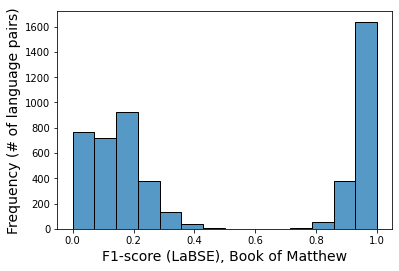

In [ ]:
# Just for kicks . . . VERY interestingly-shaped distribution
plt.xlabel('F1-score (LaBSE), Book of Matthew', fontsize=14)
plt.ylabel('Frequency (# of language pairs)', fontsize=14)
sns.histplot(bitext_f1_matt_labse)

In [ ]:
# This is just for rounding purposes: we'll round F1-scores to four decimal places
bfml = [round(res, 4) for res in bitext_f1_matt_labse]

In [ ]:
# We'll keep updating this dataframe as we add more and more variables
df1 = pd.DataFrame({'Language pair': list(matt_bitexts), 
                    'No. of sentences (Book of Matthew)': [len(matt_texts[0]) for _ in range(5050)],
                    'F1-score (LaBSE, Book of Matthew)': bfml}).to_csv('/usr2/collab/agjones/Data/bible_dataframe.csv')

**Average margin scores**

In [ ]:
avg_margins_matt_labse = [mineSentencePairs(x,y,average=True) for x,y in 
                          tqdm(itertools.combinations(matt_embs_labse, 2))]



0it [00:00, ?it/s]

1it [00:01,  1.78s/it]

3it [00:01,  1.95it/s]

5it [00:02,  3.49it/s]

7it [00:02,  5.11it/s]

9it [00:02,  6.71it/s]

11it [00:02,  8.20it/s]

13it [00:02,  9.51it/s]

15it [00:02, 10.57it/s]

17it [00:02, 11.46it/s]

19it [00:03, 11.94it/s]

21it [00:03, 12.11it/s]

23it [00:03, 11.79it/s]

25it [00:03, 11.68it/s]

27it [00:03, 11.62it/s]

29it [00:03, 11.57it/s]

31it [00:04, 11.53it/s]

33it [00:04, 12.15it/s]

35it [00:04, 12.52it/s]

37it [00:04, 12.41it/s]

39it [00:04, 12.06it/s]

41it [00:04, 11.83it/s]

43it [00:05, 11.64it/s]

45it [00:05, 12.25it/s]

47it [00:05, 12.72it/s]

49it [00:05, 13.06it/s]

51it [00:05, 13.25it/s]

53it [00:05, 13.45it/s]

55it [00:05, 13.51it/s]

57it [00:06, 13.59it/s]

59it [00:06, 13.77it/s]

61it [00:06, 13.68it/s]

63it [00:06, 13.67it/s]

65it [00:06, 13.86it/s]

67it [00:06, 13.80it/s]

69it [00:06, 13.97it/s]

71it [00:07, 13.95it/s]

73it [00:07, 13.88it/s]

75it [00:07, 13.88it/s]

77it [00:07, 13.94it/s]

79it [00

<AxesSubplot:xlabel='Avg. margin score for aligned sentences', ylabel='Frequency'>

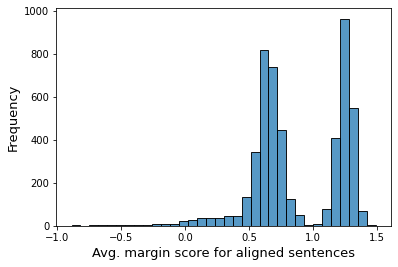

In [ ]:
plt.xlabel('Avg. margin score for aligned sentences', fontsize=13)
plt.ylabel('Frequency', fontsize=13)
sns.histplot(avg_margins_matt_labse)

**G-H**

In [ ]:
proc_matt_embs_labse = [preprocess_embeddings(embs) for embs in tqdm(matt_embs_labse)]

100%|██████████| 101/101 [00:00<00:00, 135.08it/s]


In [ ]:
matt_dist_mats_labse = [distance_matrix(embs) for embs in tqdm(proc_matt_embs_labse)]




  0%|          | 0/101 [00:00<?, ?it/s]


  7%|▋         | 7/101 [00:00<00:01, 67.21it/s]


 15%|█▍        | 15/101 [00:00<00:01, 68.91it/s]


 22%|██▏       | 22/101 [00:00<00:01, 69.37it/s]


 29%|██▊       | 29/101 [00:00<00:01, 68.63it/s]


 37%|███▋      | 37/101 [00:00<00:00, 69.27it/s]


 45%|████▍     | 45/101 [00:00<00:00, 69.47it/s]


 52%|█████▏    | 53/101 [00:00<00:00, 69.73it/s]


 60%|██████    | 61/101 [00:00<00:00, 69.86it/s]


 68%|██████▊   | 69/101 [00:00<00:00, 70.03it/s]


 76%|███████▌  | 77/101 [00:01<00:00, 69.96it/s]


 84%|████████▍ | 85/101 [00:01<00:00, 70.05it/s]


 92%|█████████▏| 93/101 [00:01<00:00, 70.13it/s]


100%|██████████| 101/101 [00:01<00:00, 69.69it/s]


In [ ]:
# # Computing the Gromov-Hausdorff distance for each language pair
# matt_gh_dists_labse = [compute_distance(l1, l2) for l1, l2 in tqdm(itertools.combinations(matt_dist_mats_labse, 2))]




  0%|          | 0/101 [02:18<?, ?it/s]



1it [00:02,  2.13s/it]


2it [00:04,  2.14s/it]


3it [00:06,  2.12s/it]


4it [00:08,  2.13s/it]


5it [00:10,  2.12s/it]


6it [00:12,  2.11s/it]


7it [00:14,  2.12s/it]


8it [00:16,  2.10s/it]


9it [00:19,  2.11s/it]


10it [00:21,  2.11s/it]


11it [00:23,  2.12s/it]


12it [00:25,  2.12s/it]


13it [00:27,  2.11s/it]


14it [00:29,  2.12s/it]


15it [00:31,  2.12s/it]


16it [00:33,  2.12s/it]


17it [00:35,  2.11s/it]


18it [00:38,  2.11s/it]


19it [00:40,  2.11s/it]


20it [00:42,  2.12s/it]


21it [00:44,  2.07s/it]


22it [00:46,  2.08s/it]


23it [00:48,  2.10s/it]


24it [00:50,  2.03s/it]


25it [00:52,  2.06s/it]


26it [00:54,  2.07s/it]


27it [00:56,  2.09s/it]


28it [00:58,  2.10s/it]


29it [01:00,  2.10s/it]


30it [01:03,  2.10s/it]


31it [01:05,  2.11s/it]


32it [01:07,  2.11s/it]


33it [01:09,  2.12s/it]


34it [01:11,  2.07s/it]


35it [01:13,  2.09s/it]


36it [01:15,  2.10s/it]


37it [01:17,  2.11s/it]


3

<AxesSubplot:xlabel='G-H distance (LaBSE), Book of Matthew', ylabel='Frequency (# language pairs)'>

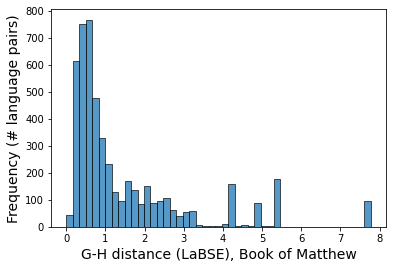

In [ ]:
plt.xlabel('G-H distance (LaBSE), Book of Matthew', fontsize=14)
plt.ylabel('Frequency (# language pairs)', fontsize=14)
sns.histplot(matt_gh_dists_labse)

In [ ]:
mgdl = [round(res, 4) for res in matt_gh_dists_labse]

In [ ]:
# We'll keep updating this dataframe as we add more and more variables
df1 = pd.DataFrame({'Language pair': list(matt_bitexts), 
                    'No. of sentences (Book of Matthew)': [len(matt_texts[0]) for _ in range(5050)],
                    'F1-score (LaBSE, Book of Matthew)': bfml,
                    'Gromov-Hausdorff dist. (LaBSE, Book of Matthew)': mgdl}).to_csv('/usr2/collab/agjones/Data/bible_dataframe.csv')

In [ ]:
# Let's examine the correlation between G-H and bitext retrieval F1
pearsonr(mgdl, bfml) # A weak but statistically significant negative correlation

(-0.3735360073658227, 5.643819356806525e-167)

**SVG**

In [ ]:
matt_svg_labse = computeSVG(proc_matt_embs_labse)

  1%|          | 1/101 [00:00<00:19,  5.18it/s]

Computing SVDs . . .


100%|██████████| 101/101 [00:19<00:00,  5.23it/s]
1288it [00:00, 6438.11it/s]

Computing SVGs . . .


5050it [00:00, 6397.25it/s]


In [ ]:
msl = [round(res, 4) for res in matt_svg_labse]

In [ ]:
os.chdir('REDACTED')

In [ ]:
bdf = pd.read_csv('Data/bible_dataframe.csv')

In [ ]:
pearsonr(msl, np.array(bdf['F1-score (LaBSE, Book of Matthew)']))

(-0.2545688246642884, 1.585179064743731e-75)

**ECOND-HM**

In [ ]:
matt_econdhm_labse = computeECOND_HM(proc_matt_embs_labse)

  1%|          | 1/101 [00:00<00:19,  5.14it/s]

Computing SVDs . . .


100%|██████████| 101/101 [00:19<00:00,  5.16it/s]
164it [00:00, 1630.37it/s]

Computing ECOND-HMs . . .


5050it [00:03, 1621.85it/s]


In [ ]:
mel = [round(res, 4) for res in matt_econdhm_labse]

In [ ]:
pearsonr(mel, np.array(bdf['F1-score (LaBSE, Book of Matthew)']))

(-0.3590365394579714, 1.6489265695746932e-153)

### Book of John

**Bitext Mining**

In [ ]:
# # Commented-out cell . . . you know the drill

# bitext_f1_john_labse = [(computeF1(mineSentencePairs(x,y)[0], gold_pairs_john))[0] 
#                         for x,y in tqdm(itertools.combinations(john_embs_labse, 2))]



0it [00:00, ?it/s]

1it [00:00,  6.30it/s]

2it [00:00,  6.16it/s]

3it [00:00,  6.12it/s]

4it [00:00,  6.12it/s]

5it [00:00,  6.04it/s]

6it [00:00,  6.05it/s]

7it [00:01,  6.05it/s]

8it [00:01,  6.10it/s]

9it [00:01,  6.09it/s]

10it [00:01,  6.09it/s]

11it [00:01,  6.08it/s]

12it [00:01,  6.09it/s]

13it [00:02,  6.10it/s]

14it [00:02,  6.13it/s]

15it [00:02,  6.20it/s]

16it [00:02,  6.25it/s]

17it [00:02,  6.32it/s]

18it [00:02,  6.32it/s]

19it [00:03,  6.31it/s]

20it [00:03,  6.32it/s]

21it [00:03,  6.37it/s]

22it [00:03,  6.35it/s]

23it [00:03,  6.33it/s]

24it [00:03,  6.35it/s]

25it [00:04,  6.27it/s]

26it [00:04,  6.22it/s]

27it [00:04,  6.17it/s]

28it [00:04,  6.17it/s]

29it [00:04,  6.14it/s]

30it [00:04,  6.11it/s]

31it [00:05,  6.10it/s]

32it [00:05,  6.09it/s]

33it [00:05,  6.08it/s]

34it [00:05,  6.13it/s]

35it [00:05,  6.10it/s]

36it [00:05,  6.08it/s]

37it [00:06,  6.07it/s]

38it [00:06,  6.06it/s]

39it [00:06,  6.07it/s]

40it [00:06,

<AxesSubplot:xlabel='F1-score (LaBSE), Book of John', ylabel='Frequency (# of language pairs)'>

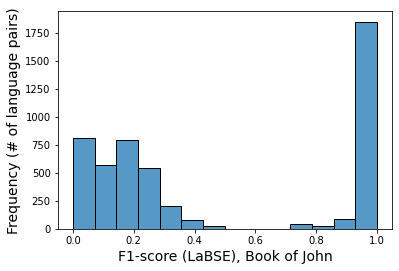

In [ ]:
plt.xlabel('F1-score (LaBSE), Book of John', fontsize=14)
plt.ylabel('Frequency (# of language pairs)', fontsize=14)
sns.histplot(bitext_f1_john_labse)

In [ ]:
# This is just for rounding purposes: we'll round F1-scores to four decimal places
bfjl = [round(res, 4) for res in bitext_f1_john_labse]

In [ ]:
# We'll keep updating this dataframe as we add more and more variables
df1 = pd.DataFrame({'Language pair': list(matt_bitexts), 
                    'No. of sentences (Book of Matthew)': [len(matt_texts[0]) for _ in range(5050)],
                    'No. of sentences (Book of John)': [len(john_texts[0]) for _ in range(5050)],
                    'F1-score (LaBSE, Book of Matthew)': bfml,
                    'F1-score (LaBSE, Book of John)': bfjl,
                    'Gromov-Hausdorff dist. (LaBSE, Book of Matthew)': mgdl}).to_csv('/usr2/collab/agjones/Data/bible_dataframe.csv')

In [ ]:
# How do the Book of Matthew and the Book of John compare? A quick look

print('Average F-1, Matthew: {}'.format(np.average(bfml)))
print('Average F-1, John: {}'.format(np.average(bfjl)))

# Format: (r, p-val)
print('Pearson correlation between Matthew and John, F-1: {}'.format(pearsonr(bfml, bfjl)))

Average F-1, Matthew: 0.47471693069306925
Average F-1, John: 0.4773295049504951
Pearson correlation between Matthew and John, F-1: (0.9652430176738314, 0.0)


**Average margin score**

In [ ]:
avg_margins_john_labse = [mineSentencePairs(x,y,average=True) for x,y in 
                          tqdm(itertools.combinations(john_embs_labse, 2))]

5050it [04:10, 20.19it/s]


**G-H**

In [ ]:
proc_john_embs_labse = [preprocess_embeddings(embs) for embs in tqdm(john_embs_labse)]

100%|██████████| 101/101 [00:00<00:00, 161.24it/s]


In [ ]:
john_dist_mats_labse = [distance_matrix(embs) for embs in tqdm(proc_john_embs_labse)]

100%|██████████| 101/101 [00:01<00:00, 66.82it/s]


In [ ]:
# Computing the Gromov-Hausdorff distance for each language pair
john_gh_dists_labse = [compute_distance(l1, l2) for l1, l2 in tqdm(itertools.combinations(john_dist_mats_labse, 2))]

667it [14:10,  1.27s/it]

In [ ]:
jgdl = [round(res, 4) for res in john_gh_dists_labse]

<AxesSubplot:ylabel='Count'>

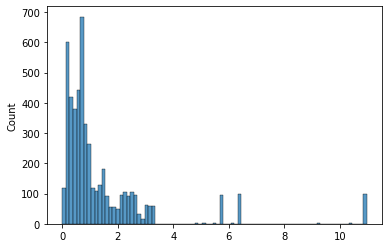

In [ ]:
sns.histplot(jgdl)

**SVG**

In [ ]:
john_svg_labse = computeSVG(proc_john_embs_labse)

In [ ]:
jsl = [round(res, 4) for res in john_svg_labse]

**ECOND-HM**

In [ ]:
john_econdhm_labse = computeECOND_HM(proc_john_embs_labse)

In [ ]:
jel = [round(res, 4) for res in john_econdhm_labse]

<AxesSubplot:ylabel='Count'>

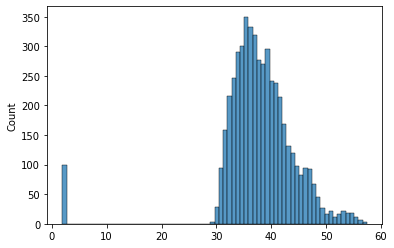

In [ ]:
sns.histplot(jel)

In [ ]:
# Update the dataframe

updated1 = pd.DataFrame({'Singular value gap (LaBSE, Book of Matthew)': msl,
                         'ECOND-HM (LaBSE, Book of Matthew)': mel,
                         'Gromov-Hausdorff dist. (LaBSE, Book of John)': jgdl,
                         'Singular value gap (LaBSE, Book of John)': jsl,
                         'ECOND-HM (LaBSE, Book of John)': jel}).to_csv('Data/bible_update1.csv')

# LASER

### Book of Matthew

**Bitext Mining**

In [ ]:
# Commented-out cell . . . you know the drill

bitext_f1_matt_laser = [(computeF1(mineSentencePairs(x,y)[0], gold_pairs_matt))[0] 
                        for x,y in tqdm(itertools.combinations(matt_embs_laser, 2))]

5050it [18:45,  4.49it/s]


In [ ]:
# This is just for rounding purposes: we'll round F1-scores to four decimal places
bfmLAS = [round(res, 4) for res in bitext_f1_matt_laser]

**Average margin score**

In [ ]:
avg_margins_matt_laser = [mineSentencePairs(x,y,average=True) for x,y in 
                          tqdm(itertools.combinations(matt_embs_laser, 2))]

5050it [07:01, 11.99it/s]


**G-H**

In [ ]:
proc_matt_embs_laser = [preprocess_embeddings(embs) for embs in tqdm(matt_embs_laser)]

100%|██████████| 101/101 [00:00<00:00, 115.02it/s]


In [ ]:
matt_dist_mats_laser = [distance_matrix(embs) for embs in tqdm(proc_matt_embs_laser)]

100%|██████████| 101/101 [00:01<00:00, 54.70it/s]


In [ ]:
# Computing the Gromov-Hausdorff distance for each language pair
matt_gh_dists_laser = [compute_distance(l1, l2) for l1, l2 in tqdm(itertools.combinations(matt_dist_mats_laser, 2))]

1187it [42:06,  2.17s/it]

In [ ]:
mgdLAS = [round(res, 4) for res in matt_gh_dists_laser]

**SVG**

In [ ]:
matt_svg_laser = computeSVG(proc_matt_embs_laser)

In [ ]:
msLAS = [round(res, 4) for res in matt_svg_laser]

**ECOND-HM**

In [ ]:
matt_econdhm_laser = computeECOND_HM(proc_matt_embs_laser)

In [ ]:
meLAS = [round(res, 4) for res in matt_econdhm_laser]

### Book of John

**Bitext Mining**

In [ ]:
# Commented-out cell . . . you know the drill

bitext_f1_john_laser = [(computeF1(mineSentencePairs(x,y)[0], gold_pairs_john))[0] 
                        for x,y in tqdm(itertools.combinations(john_embs_laser, 2))]

In [ ]:
# This is just for rounding purposes: we'll round F1-scores to four decimal places
bfjLAS = [round(res, 4) for res in bitext_f1_john_laser]

**Average margin score**

In [ ]:
avg_margins_john_laser = [mineSentencePairs(x,y,average=True) for x,y in 
                          tqdm(itertools.combinations(john_embs_laser, 2))]

5050it [04:59, 16.84it/s]


In [ ]:
avg_margins_matt_labse = [round(res,4) for res in avg_margins_matt_labse]
avg_margins_john_labse = [round(res,4) for res in avg_margins_john_labse]
avg_margins_matt_laser = [round(res,4) for res in avg_margins_matt_laser]
avg_margins_john_laser = [round(res,4) for res in avg_margins_john_laser]

In [ ]:
dftemp = pd.DataFrame({'Average margin score (LaBSE, Book of Matthew)':avg_margins_matt_labse,
             'Average margin score (LaBSE, Book of John)':avg_margins_john_labse,
             'Average margin score (LASER, Book of Matthew)':avg_margins_matt_laser,
             'Average margin score (LASER, Book of John)':avg_margins_john_laser}).round(4)

In [ ]:
dftemp.to_csv('Data/avg_margins.csv')

**G-H**

In [ ]:
proc_john_embs_laser = [preprocess_embeddings(embs) for embs in tqdm(john_embs_laser)]

In [ ]:
john_dist_mats_laser = [distance_matrix(embs) for embs in tqdm(proc_john_embs_laser)]

In [ ]:
# Computing the Gromov-Hausdorff distance for each language pair
john_gh_dists_laser = [compute_distance(l1, l2) for l1, l2 in tqdm(itertools.combinations(john_dist_mats_laser, 2))]

In [ ]:
jgdLAS = [round(res, 4) for res in john_gh_dists_laser]

**SVG**

In [ ]:
john_svg_laser = computeSVG(proc_john_embs_laser)

In [ ]:
jsLAS = [round(res, 4) for res in john_svg_laser]

**ECOND-HM**

In [ ]:
john_econdhm_laser = computeECOND_HM(proc_john_embs_laser)

In [ ]:
jeLAS = [round(res, 4) for res in john_econdhm_laser]

In [ ]:
updated2 = pd.DataFrame({'F1-score (LASER, Book of Matthew)': bfmLAS,
                         'Gromov-Hausdorff dist. (LASER, Book of Matthew)': mgdLAS,
                         'Singular value gap (LASER, Book of Matthew)': msLAS,
                         'ECOND-HM (LASER, Book of Matthew)': meLAS,
                         'F1-score (LASER, Book of John)': bfjLAS,
                         'Gromov-Hausdorff dist. (LASER, Book of John)': jgdLAS,
                         'Singular value gap (LASER, Book of John)': jsLAS,
                         'ECOND-HM (LASER, Book of John)': jeLAS}).to_csv('Data/bible_stats_LASER.csv')

# Handling independent variables (IVs)

In [ ]:
os.chdir('REDACTED')

In [ ]:
lang_df = pd.read_csv('Data/bible_vars_LANGUAGE 7.csv')

In [ ]:
lang_df

,ISO 639-3,Language,Family,Genus,Speakers,Script,Word Order,Morphology,"Train Data (total, LaBSE)","Train Data (total, LASER)",...,"In-genus Train Data (total, LASER)",Parts,Average F1 (LaBSE),Average F1 (LASER),Average G-H dist. (LaBSE),Average G-H dist. (LASER),Average SVG (LaBSE),Average SVG (LASER),Average ECOND-HM (LaBSE),Average ECOND-HM (LASER)
0,acu,Achuar-Shiwiar,Jivaroan,NaN,"5,000",Latin,NaN,NaN,NaN,NaN,...,NaN,New Testament,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,afr,Afrikaans,Indo-European,Germanic,"5,000,000",Latin,NaN,NaN,NaN,NaN,...,NaN,COMPLETE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,agr,Aguaruna,Jivaroan,NaN,"38,300",Latin,NaN,NaN,NaN,NaN,...,NaN,New Testament,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,ake,Akawaio,Carib,Northern,"4,500",Latin,NaN,NaN,NaN,NaN,...,NaN,New Testament,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,als,Albanian,Indo-European,Albanian,"3,000,000",Latin,NaN,NaN,NaN,NaN,...,NaN,COMPLETE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,wal,Wolaytta,Afro-Asiatic,Omotic,"1,230,000",Latin,NaN,NaN,NaN,NaN,...,NaN,New Testament,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
97,wol,Wolof,Niger-Congo,Atlantic-Congo,"4,000,000",Latin,NaN,NaN,NaN,NaN,...,NaN,New Testament,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
98,xho,Xhosa,Niger-Congo,Atlantic-Congo,"7,800,000",Latin,NaN,NaN,NaN,NaN,...,NaN,COMPLETE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
99,dje,Zarma,Nilo-Saharan,Songhai,"2,350,000",Latin,NaN,NaN,NaN,NaN,...,NaN,COMPLETE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
ldf = lang_df[['Language', 'Family', 'Genus', 'Speakers', 'Script']]

In [ ]:
lang_pairs = list(matt_bitexts)

### Language family dictionary

In [ ]:
for i in range(len(ldf)):
    if ldf.Language[i]=='Haitian Creole': ldf.Language[i] = 'Creole'

/share/pkg.7/python3/3.7.9/install/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3417: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exec(code_obj, self.user_global_ns, self.user_ns)


In [ ]:
ldf = ldf.sort_values('Language')

In [ ]:
lang_fam_dict = {sorted(langs)[i]:list(ldf.Family)[i] if type(list(ldf.Family)[i])==str else '' 
                 for i in range(len(ldf))}

In [ ]:
lang_fam_dict

{'Achuar': 'Jivaroan',
 'Afrikaans': 'Indo-European',
 'Aguaruna': 'Jivaroan',
 'Akawaio': 'Carib',
 'Albanian': 'Indo-European',
 'Amharic': 'Afro-Asiatic',
 'Amuzgo': 'Oto-Manguean',
 'Arabic': 'Afro-Asiatic',
 'Aukan': 'Creole',
 'Barasana': 'Tucanoan',
 'Basque': 'Basque',
 'Bulgarian': 'Indo-European',
 'Cabecar': 'Chibchan',
 'Cakchiquel': 'Mayan',
 'Campa': 'Arawakan',
 'Camsa': 'Equatorial (?)',
 'Cebuano': 'Austronesian',
 'Cherokee': 'Iroquoian',
 'Chinantec': 'Oto-Manguean',
 'Chinese': 'Sino-Tibetan',
 'Chinese-tok': 'Sino-Tibetan',
 'Coptic': 'Afro-Asiatic',
 'Creole': 'Creole',
 'Croatian': 'Indo-European',
 'Czech': 'Indo-European',
 'Danish': 'Indo-European',
 'Dinka': 'Nilo-Saharan',
 'Dutch': 'Indo-European',
 'English': 'Indo-European',
 'English-WEB': 'Indo-European',
 'Esperanto': 'Constructed',
 'Ewe': 'Niger-Congo',
 'Farsi': 'Indo-European',
 'Finnish': 'Uralic',
 'French': 'Indo-European',
 'Galela': 'West Papuan',
 'German': 'Indo-European',
 'Greek': 'Indo-Eu

### Language genus dictionary

In [ ]:
lang_gen_dict = {sorted(langs)[i]:list(ldf.Genus)[i] if type(list(ldf.Genus)[i])==str else '' 
                 for i in range(len(ldf))}

Creating two binary variables for each language pair: *same_fam(ily)* and *same gen(us)*.

In [ ]:
same_fam, same_gen = [], []
for l1,l2 in itertools.combinations(langs, 2):
    l1_fam = lang_fam_dict[l1]
    l2_fam = lang_fam_dict[l2]
    l1_gen = lang_gen_dict[l1]
    l2_gen = lang_gen_dict[l2]
    if l1_fam!='' and l2_fam!='':
        same_fam.append(int(l1_fam==l2_fam))
    if l1_gen!='' and l2_gen!='':
        same_gen.append(int(l1_gen==l2_gen))
    if l1_fam=='' or l2_fam=='':
        same_fam.append(0)
    if l1_gen=='' or l2_gen=='':
        same_gen.append(0)

In [ ]:
lang_pair_df = pd.read_csv('Data/bible_vars_LANGUAGE_PAIR.csv')

In [ ]:
lang_pair_df['Same Family?'] = same_fam
lang_pair_df['Same Genus?'] = same_gen

In [ ]:
lang_pair_df.head()

,Language pair,Parallel Train Data (LaBSE),"Monolingual Train Data (total, incl. components of bilingual data, LaBSE)","In-family Train Data (total, incl. components of bilingual data, LaBSE)","In-family Parallel Train Data (total; I.e. all pairs x,y s.t. x is in family of p1 and y is in family of p2, LaBSE)","In-genus Train Data (total, LaBSE)","In-genus Parallel Train Data (total, LaBSE)",Parallel Train Data (LASER),Monolingual Train Data (LASER),In-family Train Data (LASER),...,Same Family?,Same Genus?,Same Script?,Same Word Order?,Same Morphology?,Geographic Distance (lang2vec),Genetic Distance (lang2vec),Featural Distance (lang2vec),Inventory Distance (lang2vec),Syntactic Distance (lang2vec)
0,Galela-Cakchiquel,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Galela-Bulgarian,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Galela-Latin,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Galela-Arabic,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Galela-Finnish,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
fam_and_gen = lang_pair_df[['Language pair', 'Same Family?', 'Same Genus?']]

In [ ]:
pd.DataFrame(fam_and_gen).to_csv('Data/fam_and_gen.csv')

## [lang2vec](https://github.com/antonisa/lang2vec)

In [ ]:
# # Installing the library if it needs to be installed
# !python3 -m pip install --index-url https://test.pypi.org/simple/ --no-deps lang2vec

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://test.pypi.org/simple/
     |████████████████████████████████| 74.8 MB 42.5 MB/s eta 0:00:01   |███▋                            | 8.5 MB 9.3 MB/s eta 0:00:08     |█████▋                          | 13.0 MB 9.3 MB/s eta 0:00:07     |██████████████▍                 | 33.6 MB 37.2 MB/s eta 0:00:02     |████████████████████████▏       | 56.6 MB 37.2 MB/s eta 0:00:01     |██████████████████████████████  | 70.2 MB 37.2 MB/s eta 0:00:01


In [ ]:
import lang2vec.lang2vec as l2v

In [ ]:
def cosineSimilarity(u,v):
    u = u / np.linalg.norm(u)
    v = v / np.linalg.norm(v)
    return u.dot(v)

In [ ]:
# A little to see how close English and French are geographically (cosine similarity)
fr_geo = np.array(l2v.get_features('fra', 'geo')['fra'])
en_geo = np.array(l2v.get_features('eng', 'geo')['eng'])
cosineSimilarity(fr_geo, en_geo) # Cosine similarity computation; interval := [0,1]

0.9992555302867131

In [ ]:
l2v.LANGUAGES # Checking available languages

{'mhs',
 'yli',
 'apu',
 'srq',
 'nck',
 'lub',
 'wat',
 'ddo',
 'nih',
 'cav',
 'vil',
 'cte',
 'yuy',
 'cst',
 'num',
 'csk',
 'viv',
 'mwd',
 'dhn',
 'wmb',
 'bge',
 'xnn',
 'bbh',
 'nwx',
 'cbr',
 'las',
 'iow',
 'ksx',
 'wdj',
 'aou',
 'nss',
 'arq',
 'clc',
 'dhg',
 'rwa',
 'kha',
 'bwh',
 'kny',
 'hat',
 'snd',
 'gsg',
 'kto',
 'txu',
 'ccr',
 'mnx',
 'psd',
 'nab',
 'auc',
 'gld',
 'akx',
 'djn',
 'hke',
 'bkc',
 'shj',
 'byf',
 'tat',
 'pko',
 'buu',
 'had',
 'nuc',
 'npl',
 'jae',
 'ruo',
 'abw',
 'pay',
 'tpy',
 'tya',
 'ifa',
 'mkz',
 'hus',
 'pno',
 'zab',
 'xwg',
 'sov',
 'sun',
 'nko',
 'blx',
 'akf',
 'slk',
 'afz',
 'mnc',
 'enn',
 'kjq',
 'rbb',
 'bti',
 'apv',
 'gyb',
 'dlk',
 'gya',
 'mls',
 'guw',
 'bsq',
 'ibd',
 'ash',
 'dbi',
 'nlg',
 'bfh',
 'bfr',
 'hal',
 'inb',
 'kim',
 'knc',
 'lcm',
 'nhu',
 'bqy',
 'pma',
 'bhv',
 'bfw',
 'hmr',
 'bzs',
 'glv',
 'kbh',
 'ttc',
 'nfl',
 'bdg',
 'gow',
 'bhs',
 'ffm',
 'mvb',
 'xpe',
 'gug',
 'wnc',
 'cod',
 'izh',
 'umu',


In [ ]:
bible_iso_codes = lang_df['ISO 639-3']

In [ ]:
# Checking how many languages are supported by lang2vec
supported = [c for c in bible_iso_codes if c in l2v.LANGUAGES]
print('{}/101 languages are supported in lang2vec'.format(len(supported)))

100/101 languages are supported in lang2vec


In [ ]:
# Let's see what the unsupported language is
not_supported = [c for c in bible_iso_codes if c not in l2v.LANGUAGES]
# It's Syriac (Aramaic), which is an extinct Afro-Asiatic language
# Since it won't affect our analysis much, we'll treat it as Hebrew
# (yes, I realize this is a superficial fix, but it's better than nothing IMO)
not_supported

['arc']

In [ ]:
bible_iso_codes = list(bible_iso_codes.replace('arc', 'heb'))

In [ ]:
# List available feature sets
l2v.FEATURE_SETS

['syntax_wals',
 'phonology_wals',
 'syntax_sswl',
 'syntax_ethnologue',
 'phonology_ethnologue',
 'inventory_ethnologue',
 'inventory_phoible_aa',
 'inventory_phoible_gm',
 'inventory_phoible_saphon',
 'inventory_phoible_spa',
 'inventory_phoible_ph',
 'inventory_phoible_ra',
 'inventory_phoible_upsid',
 'syntax_knn',
 'phonology_knn',
 'inventory_knn',
 'syntax_average',
 'phonology_average',
 'inventory_average',
 'fam',
 'id',
 'geo',
 'learned']

In [ ]:
ldf = pd.read_csv('Data/bible_vars_LANGUAGE 7.csv')

In [ ]:
ldf_langs = list(ldf.Language)

In [ ]:
for i in range(len(ldf_langs)):
    if ldf_langs[i]=='Haitian Creole': ldf_langs[i]='Creole'

In [ ]:
for i in range(len(ldf_langs)):
    if ldf_langs[i]!=sorted(langs)[i]:
        ldf_langs[i] = sorted(langs)[i]

In [ ]:
iso_639_3 = list(ldf['ISO 639-3'])

In [ ]:
iso_639_3.remove('hat')
iso_639_3.insert(22, 'hat')

In [ ]:
lang_to_639_3 = {l:c for l,c in zip(ldf_langs, iso_639_3)}

In [ ]:
lang_to_639_3

{'Achuar': 'acu',
 'Afrikaans': 'afr',
 'Aguaruna': 'agr',
 'Akawaio': 'ake',
 'Albanian': 'als',
 'Amharic': 'amh',
 'Amuzgo': 'amu',
 'Arabic': 'arb',
 'Aukan': 'djk',
 'Barasana': 'bsn',
 'Basque': 'eus',
 'Bulgarian': 'bul',
 'Cabecar': 'cjp',
 'Cakchiquel': 'cak',
 'Campa': 'cni',
 'Camsa': 'kbh',
 'Cebuano': 'ceb',
 'Cherokee': 'chr',
 'Chinantec': 'chq',
 'Chinese': 'cmn',
 'Chinese-tok': 'cmn',
 'Coptic': 'cop',
 'Creole': 'hat',
 'Croatian': 'hrv',
 'Czech': 'ces',
 'Danish': 'dan',
 'Dinka': 'dik',
 'Dutch': 'nld',
 'English': 'eng',
 'English-WEB': 'eng',
 'Esperanto': 'epo',
 'Ewe': 'ewe',
 'Farsi': 'pes',
 'Finnish': 'fin',
 'French': 'fra',
 'Galela': 'gbi',
 'German': 'deu',
 'Greek': 'ell',
 'Gujarati': 'guj',
 'Hebrew': 'heb',
 'Hindi': 'hin',
 'Hungarian': 'hun',
 'Icelandic': 'isl',
 'Indonesian': 'ind',
 'Italian': 'ita',
 'Jakalteko': 'jai',
 'Japanese': 'jpn',
 'Japanese-tok': 'jpn',
 "K'iche'": 'kab',
 "K'iche'-SIL": 'kan',
 'Kabyle': 'quc',
 'Kannada': 'quc',
 '

In [ ]:
bible_iso_codes = [lang_to_639_3[l] for l in langs if l in lang_to_639_3]

### Geographic distance

In [ ]:
geo_vecs = [np.array(l2v.get_features(lang, 'geo')[lang]) for 
            lang in tqdm(bible_iso_codes)]



  0%|          | 0/101 [00:00<?, ?it/s]

  1%|          | 1/101 [00:00<00:16,  6.07it/s]

  2%|▏         | 2/101 [00:00<00:15,  6.24it/s]

  3%|▎         | 3/101 [00:00<00:15,  6.23it/s]

  4%|▍         | 4/101 [00:00<00:15,  6.23it/s]

  5%|▍         | 5/101 [00:00<00:15,  6.30it/s]

  6%|▌         | 6/101 [00:00<00:15,  6.28it/s]

  7%|▋         | 7/101 [00:01<00:14,  6.32it/s]

  8%|▊         | 8/101 [00:01<00:14,  6.30it/s]

  9%|▉         | 9/101 [00:01<00:14,  6.30it/s]

 10%|▉         | 10/101 [00:01<00:14,  6.27it/s]

 11%|█         | 11/101 [00:01<00:14,  6.35it/s]

 12%|█▏        | 12/101 [00:01<00:13,  6.40it/s]

 13%|█▎        | 13/101 [00:02<00:13,  6.44it/s]

 14%|█▍        | 14/101 [00:02<00:13,  6.45it/s]

 15%|█▍        | 15/101 [00:02<00:13,  6.44it/s]

 16%|█▌        | 16/101 [00:02<00:13,  6.43it/s]

 17%|█▋        | 17/101 [00:02<00:13,  6.43it/s]

 18%|█▊        | 18/101 [00:02<00:12,  6.43it/s]

 19%|█▉        | 19/101 [00:02<00:12,  6.45it/s]

 20%|█▉        |

In [ ]:
geo_dists = [(1-cosineSimilarity(u,v)) for u,v in 
             tqdm(itertools.combinations(geo_vecs, 2))]



5050it [00:00, 54850.50it/s]


### Syntactic distance

In [ ]:
syn_vecs = [np.array(l2v.get_features(lang, 'syntax_knn')[lang]) for 
            lang in tqdm(bible_iso_codes)]



  0%|          | 0/101 [00:00<?, ?it/s]

  2%|▏         | 2/101 [00:00<00:06, 15.73it/s]

  4%|▍         | 4/101 [00:00<00:06, 15.72it/s]

  6%|▌         | 6/101 [00:00<00:06, 15.79it/s]

  8%|▊         | 8/101 [00:00<00:05, 15.78it/s]

 10%|▉         | 10/101 [00:00<00:05, 15.73it/s]

 12%|█▏        | 12/101 [00:00<00:05, 15.72it/s]

 14%|█▍        | 14/101 [00:00<00:05, 15.75it/s]

 16%|█▌        | 16/101 [00:01<00:05, 15.74it/s]

 18%|█▊        | 18/101 [00:01<00:05, 15.81it/s]

 20%|█▉        | 20/101 [00:01<00:05, 15.82it/s]

 22%|██▏       | 22/101 [00:01<00:04, 15.80it/s]

 24%|██▍       | 24/101 [00:01<00:04, 15.79it/s]

 26%|██▌       | 26/101 [00:01<00:04, 15.73it/s]

 28%|██▊       | 28/101 [00:01<00:04, 15.70it/s]

 30%|██▉       | 30/101 [00:01<00:04, 15.70it/s]

 32%|███▏      | 32/101 [00:02<00:04, 15.74it/s]

 34%|███▎      | 34/101 [00:02<00:04, 15.81it/s]

 36%|███▌      | 36/101 [00:02<00:04, 15.81it/s]

 38%|███▊      | 38/101 [00:02<00:03, 15.80it/s]

 40%|███▉  

In [ ]:
syn_dists = [(1-cosineSimilarity(u,v))for u,v in 
             tqdm(itertools.combinations(syn_vecs, 2))]



5050it [00:00, 56840.56it/s]


### Inventory distance

In [ ]:
inv_vecs = [np.array(l2v.get_features(lang, 'inventory_knn')[lang]) for 
            lang in tqdm(bible_iso_codes)]



  0%|          | 0/101 [00:00<?, ?it/s]

  2%|▏         | 2/101 [00:00<00:08, 11.30it/s]

  4%|▍         | 4/101 [00:00<00:08, 11.34it/s]

  6%|▌         | 6/101 [00:00<00:08, 11.43it/s]

  8%|▊         | 8/101 [00:00<00:08, 11.46it/s]

 10%|▉         | 10/101 [00:00<00:07, 11.48it/s]

 12%|█▏        | 12/101 [00:01<00:07, 11.51it/s]

 14%|█▍        | 14/101 [00:01<00:07, 11.52it/s]

 16%|█▌        | 16/101 [00:01<00:07, 11.53it/s]

 18%|█▊        | 18/101 [00:01<00:07, 11.54it/s]

 20%|█▉        | 20/101 [00:01<00:07, 11.53it/s]

 22%|██▏       | 22/101 [00:01<00:06, 11.54it/s]

 24%|██▍       | 24/101 [00:02<00:06, 11.53it/s]

 26%|██▌       | 26/101 [00:02<00:06, 11.54it/s]

 28%|██▊       | 28/101 [00:02<00:06, 11.55it/s]

 30%|██▉       | 30/101 [00:02<00:06, 11.57it/s]

 32%|███▏      | 32/101 [00:02<00:05, 11.57it/s]

 34%|███▎      | 34/101 [00:02<00:05, 11.58it/s]

 36%|███▌      | 36/101 [00:03<00:05, 11.59it/s]

 38%|███▊      | 38/101 [00:03<00:05, 11.59it/s]

 40%|███▉  

In [ ]:
inv_dists = [(1-cosineSimilarity(u,v))for u,v in 
             tqdm(itertools.combinations(inv_vecs, 2))]



0it [00:00, ?it/s]

5050it [00:00, 47340.51it/s]


### Phonological distance

In [ ]:
phon_vecs = [np.array(l2v.get_features(lang, 'phonology_knn')[lang]) for 
            lang in tqdm(bible_iso_codes)]



  0%|          | 0/101 [00:00<?, ?it/s]

  2%|▏         | 2/101 [00:00<00:05, 18.92it/s]

  5%|▍         | 5/101 [00:00<00:04, 23.54it/s]

  9%|▉         | 9/101 [00:00<00:03, 27.29it/s]

 12%|█▏        | 12/101 [00:00<00:03, 27.97it/s]

 15%|█▍        | 15/101 [00:00<00:03, 27.91it/s]

 18%|█▊        | 18/101 [00:00<00:04, 18.46it/s]

 21%|██        | 21/101 [00:01<00:04, 16.58it/s]

 24%|██▍       | 24/101 [00:01<00:04, 18.74it/s]

 27%|██▋       | 27/101 [00:01<00:03, 20.74it/s]

 30%|██▉       | 30/101 [00:01<00:03, 22.71it/s]

 33%|███▎      | 33/101 [00:01<00:02, 23.42it/s]

 36%|███▌      | 36/101 [00:01<00:02, 24.01it/s]

 39%|███▊      | 39/101 [00:01<00:02, 23.88it/s]

 42%|████▏     | 42/101 [00:01<00:02, 22.34it/s]

 45%|████▍     | 45/101 [00:02<00:02, 22.55it/s]

 48%|████▊     | 48/101 [00:02<00:02, 23.43it/s]

 50%|█████     | 51/101 [00:02<00:02, 24.92it/s]

 53%|█████▎    | 54/101 [00:02<00:01, 25.75it/s]

 56%|█████▋    | 57/101 [00:02<00:01, 25.61it/s]

 59%|█████

In [ ]:
phon_dists = [(1-cosineSimilarity(u,v))for u,v in 
             tqdm(itertools.combinations(phon_vecs, 2))]



5050it [00:00, 78504.26it/s]


In [ ]:
pd.DataFrame({'Phonological Distance (lang2vec)':[round(res, 4) for res in phon_dists]}).to_csv('Data/phonological_dists.csv')

In [ ]:
pd.DataFrame({'Geographic distance': [round(res, 4) for res in geo_dists],
              'Syntactic distance': [round(res, 4) for res in syn_dists],
              'Inventory distance': [round(res, 4) for res in inv_dists],
              'Phonological distance': [round(res, 4) for res in phon_dists]}).to_csv('Data/bible_typology_dists.csv')

NameError: name 'geo_dists' is not defined

## Language-centric averages of DVs

In [ ]:
pair_dv_master = pd.read_csv('Data/bible_multilingual_DV 2.csv')

In [ ]:
pair_dv_master

,Language pair,"F1-score (LaBSE, Book of Matthew)","F1-score (LaBSE, Book of John)","F1-score (LASER, Book of Matthew)","F1-score (LASER, Book of John)","Gromov-Hausdorff dist. (LaBSE, Book of Matthew)","Gromov-Hausdorff dist. (LaBSE, Book of John)","Gromov-Hausdorff dist. (LASER, Book of Matthew)","Gromov-Hausdorff dist. (LASER, Book of John)","Singular value gap (LaBSE, Book of Matthew)",...,"Singular value gap (LASER, Book of Matthew)","Singular value gap (LASER, Book of John)","ECOND-HM (LaBSE, Book of Matthew)","ECOND-HM (LaBSE, Book of John)","ECOND-HM (LASER, Book of Matthew)","ECOND-HM (LASER, Book of John)","Average margin score (LaBSE, Book of Matthew)","Average margin score (LaBSE, Book of John)","Average margin score (LASER, Book of Matthew)","Average margin score (LASER, Book of John)"
0,Galela-Cakchiquel,0.1605,0.1249,0.0000,0.0000,1.5196,2.3855,1.7168,2.3155,3.1158,...,20.1494,16294.4579,51.6657,43.6778,44.2416,39.5006,0.7487,0.7571,0.6161,0.6249
1,Galela-Bulgarian,0.1746,0.0000,0.0092,0.0000,2.3620,3.0126,2.1220,2.6347,709.2671,...,101.3729,16834.3983,39.9786,37.2844,30.7275,27.9837,0.6376,0.3610,0.6143,0.5613
2,Galela-Latin,0.1587,0.1411,0.0000,0.0000,2.3174,2.9874,2.0993,2.6347,596.0366,...,73.4569,16826.5229,38.9175,37.5212,32.2263,29.6479,0.5532,0.6061,0.6345,0.6594
3,Galela-Arabic,0.1593,0.1363,0.0000,0.0023,2.2922,3.0035,2.1027,2.6347,221.9072,...,97.5742,16828.3545,46.8657,42.6475,28.0550,27.6817,0.6199,0.6529,0.6359,0.6534
4,Galela-Finnish,0.2123,0.1670,0.0037,0.0023,2.2035,3.0207,2.0782,2.6347,643.4390,...,83.0832,16788.4933,39.9540,37.5089,29.6398,28.5350,0.6897,0.7232,0.6626,0.6760
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5045,Hebrew-French,0.9820,0.9937,0.4367,0.4369,0.5811,0.5264,0.5766,0.4718,65.5300,...,1.6137,0.3775,35.4796,36.6367,26.8957,24.8202,1.2706,1.2671,0.8347,0.8744
5046,Hebrew-Afrikaans,0.9868,0.9971,0.3367,0.3960,0.3619,0.7097,0.3633,0.3066,100.7003,...,0.6870,0.1547,34.6102,35.9523,22.2110,23.4398,1.2703,1.2696,0.9010,0.9203
5047,Kabyle-French,0.1738,0.1572,0.0488,0.0572,0.7604,0.4889,0.6997,0.5092,741.7724,...,27.3749,13.3069,36.7255,35.1091,31.6891,27.5358,0.7001,0.7018,0.7113,0.7566
5048,Kabyle-Afrikaans,0.1653,0.1551,0.0330,0.0422,0.7539,0.4796,0.4974,0.5640,845.4273,...,29.9860,12.3954,35.7947,34.4801,25.3816,25.8471,0.6766,0.6956,0.7901,0.8104


In [ ]:
labse_f1, laser_f1 = {}, {}
labse_gh, laser_gh = {}, {}
labse_svg, laser_svg = {}, {}
labse_econdhm, laser_econdhm = {}, {}
labse_avgm, laser_avgm = {}, {}
i = 0
for l1,l2 in tqdm(itertools.combinations(langs, 2)):
    
    if l1 not in labse_f1:
        labse_f1[l1] = [np.average(pair_dv_master['F1-score (LaBSE, Book of Matthew)'][i]
                                       +pair_dv_master['F1-score (LaBSE, Book of John)'][i])]
    elif l1 in labse_f1:
        labse_f1[l1].append(np.average(pair_dv_master['F1-score (LaBSE, Book of Matthew)'][i]
                                       +pair_dv_master['F1-score (LaBSE, Book of John)'][i]))
    
    if l1 not in labse_gh:
        labse_gh[l1] = [np.average(pair_dv_master['Gromov-Hausdorff dist. (LaBSE, Book of Matthew)'][i]
                                       +pair_dv_master['Gromov-Hausdorff dist. (LaBSE, Book of John)'][i])]
    elif l1 in labse_gh:
        labse_gh[l1].append(np.average(pair_dv_master['Gromov-Hausdorff dist. (LaBSE, Book of Matthew)'][i]
                                +pair_dv_master['Gromov-Hausdorff dist. (LaBSE, Book of John)'][i]))
    
    
    if l1 not in labse_svg:
        labse_svg[l1] = [np.average(pair_dv_master['Singular value gap (LaBSE, Book of Matthew)'][i]
                                       +pair_dv_master['F1-score (LaBSE, Book of John)'][i])]
    elif l1 in labse_svg:
        labse_svg[l1].append(np.average(pair_dv_master['Singular value gap (LaBSE, Book of Matthew)'][i]
    +pair_dv_master['F1-score (LaBSE, Book of John)'][i]))
        
        
    if l1 not in labse_econdhm:
        labse_econdhm[l1] = [np.average(pair_dv_master['ECOND-HM (LaBSE, Book of Matthew)'][i]
                                       +pair_dv_master['F1-score (LaBSE, Book of John)'][i])]
    elif l1 in labse_econdhm:
        labse_econdhm[l1].append(np.average(pair_dv_master['ECOND-HM (LaBSE, Book of Matthew)'][i]
+pair_dv_master['F1-score (LaBSE, Book of John)'][i]))
        
    if l1 not in labse_avgm:
        labse_avgm[l1] = [np.average(pair_dv_master['Average margin score (LaBSE, Book of Matthew)'][i]
                                       +pair_dv_master['Average margin score (LaBSE, Book of John)'][i])]
    elif l1 in labse_avgm:
        labse_avgm[l1].append(np.average(pair_dv_master['Average margin score (LaBSE, Book of Matthew)'][i]
                                       +pair_dv_master['Average margin score (LaBSE, Book of John)'][i]))
    
    
    if l1 not in laser_f1:
        laser_f1[l1] = [np.average(pair_dv_master['F1-score (LASER, Book of Matthew)'][i]
                                       +pair_dv_master['F1-score (LASER, Book of John)'][i])]
    elif l1 in laser_f1:
        laser_f1[l1].append(np.average(pair_dv_master['F1-score (LASER, Book of Matthew)'][i]
          +pair_dv_master['F1-score (LASER, Book of John)'][i]))                  
    
    
    if l1 not in laser_gh:
        laser_gh[l1] = [np.average(pair_dv_master['Gromov-Hausdorff dist. (LASER, Book of Matthew)'][i]
                                       +pair_dv_master['F1-score (LASER, Book of John)'][i])]
    elif l1 in laser_gh:
        laser_gh[l1].append(np.average(pair_dv_master['Gromov-Hausdorff dist. (LASER, Book of Matthew)'][i]
         +pair_dv_master['Gromov-Hausdorff dist. (LASER, Book of John)'][i]))           
   

    if l1 not in laser_svg:
        laser_svg[l1] = [np.average(pair_dv_master['Singular value gap (LASER, Book of Matthew)'][i]
                                       +pair_dv_master['Singular value gap (LASER, Book of John)'][i])]
    elif l1 in laser_svg:
        laser_svg[l1].append(np.average(pair_dv_master['Singular value gap (LASER, Book of Matthew)'][i]
                +pair_dv_master['Singular value gap (LASER, Book of John)'][i]))                       
    
    
    if l1 not in laser_econdhm:
        laser_econdhm[l1] = [np.average(pair_dv_master['ECOND-HM (LASER, Book of Matthew)'][i]
                                       +pair_dv_master['ECOND-HM (LASER, Book of John)'][i])]
    elif l1 in laser_econdhm:
        laser_econdhm[l1].append(np.average(pair_dv_master['ECOND-HM (LASER, Book of Matthew)'][i]
                                       +pair_dv_master['ECOND-HM (LASER, Book of John)'][i]))
    
    if l1 not in laser_avgm:
        laser_avgm[l1] = [np.average(pair_dv_master['Average margin score (LASER, Book of Matthew)'][i]
                                       +pair_dv_master['Average margin score (LASER, Book of John)'][i])]
    elif l1 in laser_avgm:
        laser_avgm[l1].append(np.average(pair_dv_master['Average margin score (LASER, Book of Matthew)'][i]
                                       +pair_dv_master['Average margin score (LASER, Book of John)'][i]))
        
        
    
    ##########################################################################################
        
        
        
    if l2 not in labse_f1:
        labse_f1[l2] = [np.average(pair_dv_master['F1-score (LaBSE, Book of Matthew)'][i]
                                       +pair_dv_master['F1-score (LaBSE, Book of John)'][i])]
    elif l2 in labse_f1:
        labse_f1[l2].append(np.average(pair_dv_master['F1-score (LaBSE, Book of Matthew)'][i]
                                       +pair_dv_master['F1-score (LaBSE, Book of John)'][i]))
    
    if l2 not in labse_gh:
        labse_gh[l2] = [np.average(pair_dv_master['Gromov-Hausdorff dist. (LaBSE, Book of Matthew)'][i]
                                       +pair_dv_master['Gromov-Hausdorff dist. (LaBSE, Book of John)'][i])]
    elif l2 in labse_gh:
        labse_gh[l2].append(np.average(pair_dv_master['Gromov-Hausdorff dist. (LaBSE, Book of Matthew)'][i]
                                +pair_dv_master['Gromov-Hausdorff dist. (LaBSE, Book of John)'][i]))
    
    
    if l2 not in labse_svg:
        labse_svg[l2] = [np.average(pair_dv_master['Singular value gap (LaBSE, Book of Matthew)'][i]
                                       +pair_dv_master['F1-score (LaBSE, Book of John)'][i])]
    elif l2 in labse_svg:
        labse_svg[l2].append(np.average(pair_dv_master['Singular value gap (LaBSE, Book of Matthew)'][i]
    +pair_dv_master['F1-score (LaBSE, Book of John)'][i]))
        
        
    if l2 not in labse_econdhm:
        labse_econdhm[l2] = [np.average(pair_dv_master['ECOND-HM (LaBSE, Book of Matthew)'][i]
                                       +pair_dv_master['F1-score (LaBSE, Book of John)'][i])]
    elif l2 in labse_econdhm:
        labse_econdhm[l2].append(np.average(pair_dv_master['ECOND-HM (LaBSE, Book of Matthew)'][i]
+pair_dv_master['F1-score (LaBSE, Book of John)'][i]))
        
    if l2 not in labse_avgm:
        labse_avgm[l2] = [np.average(pair_dv_master['Average margin score (LaBSE, Book of Matthew)'][i]
                                       +pair_dv_master['Average margin score (LaBSE, Book of John)'][i])]
    elif l2 in labse_avgm:
        labse_avgm[l2].append(np.average(pair_dv_master['Average margin score (LaBSE, Book of Matthew)'][i]
                                       +pair_dv_master['Average margin score (LaBSE, Book of John)'][i]))
    
    
    if l2 not in laser_f1:
        laser_f1[l2] = [np.average(pair_dv_master['F1-score (LASER, Book of Matthew)'][i]
                                       +pair_dv_master['F1-score (LASER, Book of John)'][i])]
    elif l2 in laser_f1:
        laser_f1[l2].append(np.average(pair_dv_master['F1-score (LASER, Book of Matthew)'][i]
          +pair_dv_master['F1-score (LASER, Book of John)'][i]))                  
    
    
    if l2 not in laser_gh:
        laser_gh[l2] = [np.average(pair_dv_master['Gromov-Hausdorff dist. (LASER, Book of Matthew)'][i]
                                       +pair_dv_master['F1-score (LASER, Book of John)'][i])]
    elif l2 in laser_gh:
        laser_gh[l2].append(np.average(pair_dv_master['Gromov-Hausdorff dist. (LASER, Book of Matthew)'][i]
         +pair_dv_master['Gromov-Hausdorff dist. (LASER, Book of John)'][i]))           
   

    if l2 not in laser_svg:
        laser_svg[l2] = [np.average(pair_dv_master['Singular value gap (LASER, Book of Matthew)'][i]
                                       +pair_dv_master['Singular value gap (LASER, Book of John)'][i])]
    elif l2 in laser_svg:
        laser_svg[l2].append(np.average(pair_dv_master['Singular value gap (LASER, Book of Matthew)'][i]
                +pair_dv_master['Singular value gap (LASER, Book of John)'][i]))                       
    
    
    if l2 not in laser_econdhm:
        laser_econdhm[l2] = [np.average(pair_dv_master['ECOND-HM (LASER, Book of Matthew)'][i]
                                       +pair_dv_master['ECOND-HM (LASER, Book of John)'][i])]
    elif l2 in laser_econdhm:
        laser_econdhm[l2].append(np.average(pair_dv_master['ECOND-HM (LASER, Book of Matthew)'][i]
                                       +pair_dv_master['ECOND-HM (LASER, Book of John)'][i]))
    
    if l2 not in laser_avgm:
        laser_avgm[l2] = [np.average(pair_dv_master['Average margin score (LASER, Book of Matthew)'][i]
                                       +pair_dv_master['Average margin score (LASER, Book of John)'][i])]
    elif l2 in laser_avgm:
        laser_avgm[l2].append(np.average(pair_dv_master['Average margin score (LASER, Book of Matthew)'][i]
                                       +pair_dv_master['Average margin score (LASER, Book of John)'][i]))
    
    i+=1



0it [00:00, ?it/s]

275it [00:00, 2743.34it/s]

550it [00:00, 2694.23it/s]

820it [00:00, 2694.88it/s]

1092it [00:00, 2702.86it/s]

1368it [00:00, 2721.73it/s]

1655it [00:00, 2769.23it/s]

1935it [00:00, 2777.99it/s]

2222it [00:00, 2804.61it/s]

2503it [00:00, 2695.20it/s]

2787it [00:01, 2736.29it/s]

3071it [00:01, 2766.98it/s]

3352it [00:01, 2777.46it/s]

3638it [00:01, 2801.47it/s]

3927it [00:01, 2826.86it/s]

4210it [00:01, 2824.75it/s]

4500it [00:01, 2845.76it/s]

5050it [00:01, 2785.12it/s]


In [ ]:
labse_f1, 
laser_f1, 
labse_gh, 
laser_gh, 
labse_svg, 
laser_svg, 
labse_econdhm, 
laser_econdhm = 

{k:.5*np.average(v) for k,v in zip(labse_f1.keys(), labse_f1.values())},
{k:.5*np.average(v) for k,v in zip(laser_f1.keys(), laser_f1.values())}, 
{k:.5*np.average(v) for k,v in zip(labse_gh.keys(), labse_gh.values())}, 
{k:.5*np.average(v) for k,v in zip(laser_gh.keys(), laser_gh.values())},
{k:.5*np.average(v) for k,v in zip(labse_svg.keys(), labse_svg.values())},
{k:.5*np.average(v) for k,v in zip(laser_svg.keys(), laser_svg.values())},
{k:.5*np.average(v) for k,v in zip(labse_econdhm.keys(), labse_econdhm.values())},
{k:.5*np.average(v) for k,v in zip(laser_econdhm.keys(), laser_econdhm.values())}

In [ ]:
labse_avgm, laser_avgm = {k:.5*np.average(v) for k,v in zip(labse_avgm.keys(), labse_avgm.values())},{k:.5*np.average(v) for k,v in zip(laser_avgm.keys(), laser_avgm.values())}

In [ ]:
pd.DataFrame({'Grand mean margin score (LaBSE)': [round(res, 4) for res in labse_avgm.values()],
              'Grand mean margin score (LASER)': [round(res, 4) for res in laser_avgm.values()]}).to_csv('Data/avgm_avg.csv')

In [ ]:
pd.DataFrame({'Average F1 (LaBSE)': [round(res, 4) for res in labse_f1.values()],
              'Average F1 (LASER)': [round(res, 4) for res in laser_f1.values()],
              'Average G-H dist. (LaBSE)': [round(res, 4) for res in labse_gh.values()],
              'Average G-H dist. (LASER)': [round(res, 4) for res in laser_gh.values()],
              'Average SVG (LaBSE)': [round(res, 4) for res in labse_svg.values()],
              'Average SVG (LASER)': [round(res, 4) for res in laser_svg.values()],
              'Average ECOND-HM (LaBSE)': [round(res, 4) for res in labse_econdhm.values()],
              'Average ECOND-HM (LASER)': [round(res, 4) for res in laser_econdhm.values()]}).to_csv('Data/lang_dv_avg.csv')

### Checking some correlations between IVs and DVs

In [ ]:
f1_labse_matt = pair_dv_master['F1-score (LaBSE, Book of Matthew)']
svg_labse_matt = pair_dv_master['Singular value gap (LaBSE, Book of Matthew)']
gh_labse_matt = pair_dv_master['Gromov-Hausdorff dist. (LaBSE, Book of Matthew)']
econdhm_labse_matt = pair_dv_master['ECOND-HM (LaBSE, Book of Matthew)']

f1_labse_john = pair_dv_master['F1-score (LaBSE, Book of John)']
svg_labse_john = pair_dv_master['Singular value gap (LaBSE, Book of John)']
gh_labse_john = pair_dv_master['Gromov-Hausdorff dist. (LaBSE, Book of John)']
econdhm_labse_john = pair_dv_master['ECOND-HM (LaBSE, Book of John)']

In [ ]:
# Just for examining correlations
temp_df = pd.DataFrame({'F1 (LaBSE, Matthew)': f1_labse_matt,
                        'F1 (LaBSE, John)': f1_labse_john,
                        'SVG (LaBSE, Matthew)':svg_labse_matt,
                        'SVG (LaBSE, John)':svg_labse_john,
                        'GH (LaBSE, Matthew)':gh_labse_matt,
                        'GH (LaBSE, John)':gh_labse_john,
                        'ECOND-HM (LaBSE, Matthew)':econdhm_labse_matt,
                        'ECOND-HM (LaBSE, John)':econdhm_labse_john,
                        'Geo. dist.':geo_dists,
                        'Syn. dist.':syn_dists,
                        'Inv. dist.':inv_dists})

Utility function; thanks [toto_tico](https://stackoverflow.com/questions/25571882/pandas-columns-correlation-with-statistical-significance)

In [ ]:
def calculate_pvalues(df):
    df = df.dropna()._get_numeric_data()
    dfcols = pd.DataFrame(columns=df.columns)
    pvalues = dfcols.transpose().join(dfcols, how='outer')
    for r in df.columns:
        for c in df.columns:
            pvalues[r][c] = round(pearsonr(df[r], df[c])[1], 6)
    return pvalues

In [ ]:
temp_df.corr()

,"F1 (LaBSE, Matthew)","F1 (LaBSE, John)","SVG (LaBSE, Matthew)","SVG (LaBSE, John)","GH (LaBSE, Matthew)","GH (LaBSE, John)","ECOND-HM (LaBSE, Matthew)","ECOND-HM (LaBSE, John)",Geo. dist.,Syn. dist.,Inv. dist.
"F1 (LaBSE, Matthew)",1.000000,0.965243,-0.254569,-0.266579,-0.373536,-0.362070,-0.359037,-0.267691,-0.324004,-0.274370,-0.154889
"F1 (LaBSE, John)",0.965243,1.000000,-0.254460,-0.266039,-0.351753,-0.353428,-0.333289,-0.244806,-0.302559,-0.248639,-0.153291
"SVG (LaBSE, Matthew)",-0.254569,-0.254460,1.000000,0.993651,0.385707,0.425452,-0.329838,-0.329867,-0.079629,-0.056590,0.085775
"SVG (LaBSE, John)",-0.266579,-0.266039,0.993651,1.000000,0.417360,0.467505,-0.362231,-0.363925,-0.074925,-0.048307,0.103372
"GH (LaBSE, Matthew)",-0.373536,-0.351753,0.385707,0.417360,1.000000,0.891190,0.058177,0.065802,0.071118,0.108223,0.104391
"GH (LaBSE, John)",-0.362070,-0.353428,0.425452,0.467505,0.891190,1.000000,0.094767,0.128075,0.080919,0.103046,0.055571
"ECOND-HM (LaBSE, Matthew)",-0.359037,-0.333289,-0.329838,-0.362231,0.058177,0.094767,1.000000,0.970583,0.194474,0.178079,-0.113386
"ECOND-HM (LaBSE, John)",-0.267691,-0.244806,-0.329867,-0.363925,0.065802,0.128075,0.970583,1.000000,0.173199,0.165319,-0.134932
Geo. dist.,-0.324004,-0.302559,-0.079629,-0.074925,0.071118,0.080919,0.194474,0.173199,1.000000,0.360250,0.193981
Syn. dist.,-0.274370,-0.248639,-0.056590,-0.048307,0.108223,0.103046,0.178079,0.165319,0.360250,1.000000,0.197475


In [ ]:
calculate_pvalues(temp_df)

,"F1 (LaBSE, Matthew)","F1 (LaBSE, John)","SVG (LaBSE, Matthew)","SVG (LaBSE, John)","GH (LaBSE, Matthew)","GH (LaBSE, John)","ECOND-HM (LaBSE, Matthew)","ECOND-HM (LaBSE, John)",Geo. dist.,Syn. dist.,Inv. dist.
"F1 (LaBSE, Matthew)",0,0,0,0,0,0,0,0,0,0,0
"F1 (LaBSE, John)",0,0,0,0,0,0,0,0,0,0,0
"SVG (LaBSE, Matthew)",0,0,0,0,0,0,0,0,0,5.7e-05,0
"SVG (LaBSE, John)",0,0,0,0,0,0,0,0,0,0.000595,0
"GH (LaBSE, Matthew)",0,0,0,0,0,0,3.5e-05,3e-06,0,0,0
"GH (LaBSE, John)",0,0,0,0,0,0,0,0,0,0,7.8e-05
"ECOND-HM (LaBSE, Matthew)",0,0,0,0,3.5e-05,0,0,0,0,0,0
"ECOND-HM (LaBSE, John)",0,0,0,0,3e-06,0,0,0,0,0,0
Geo. dist.,0,0,0,0,0,0,0,0,0,0,0
Syn. dist.,0,0,5.7e-05,0.000595,0,0,0,0,0,0,0


### Applying some typological variables to language pairs

In [ ]:
ldf_temp = pd.read_csv('Data/bible_vars_LANGUAGE 10.csv')

In [ ]:
ldf_temp.head()

,ISO 639-3,Language,Family,Genus,Speakers,Script,Basic Word Order,Polysynthetic?,"Train Data (total, LaBSE)","Train Data (total, LASER)",...,"In-genus Train Data (total, LASER)",Parts,Average F1 (LaBSE),Average F1 (LASER),Average G-H dist. (LaBSE),Average G-H dist. (LASER),Average SVG (LaBSE),Average SVG (LASER),Average ECOND-HM (LaBSE),Average ECOND-HM (LASER)
0,acu,Achuar-Shiwiar,Jivaroan,NaN,"5,000",Latin,SOV,0,NaN,NaN,...,NaN,New Testament,0.0757,0.0017,2.3781,2.1466,13602.1075,45577.7052,0.1513,0.0017
1,afr,Afrikaans,Indo-European,Germanic,"5,000,000",Latin,SVO,0,NaN,NaN,...,NaN,COMPLETE,0.0796,0.0006,1.0679,1.0767,13590.4688,40369.8357,0.1593,0.0006
2,agr,Aguaruna,Jivaroan,NaN,"38,300",Latin,SOV,1,NaN,NaN,...,NaN,New Testament,0.1592,0.1163,1.0348,1.0228,14199.8104,41266.9780,0.3183,0.1163
3,ake,Akawaio,Carib,Northern,"4,500",Latin,SOV,1,NaN,NaN,...,NaN,New Testament,0.3280,0.0428,1.0134,1.1434,14121.7230,41196.5490,0.6560,0.0428
4,als,Albanian,Indo-European,Albanian,"3,000,000",Latin,SVO,0,NaN,NaN,...,NaN,COMPLETE,0.3310,0.2446,1.0041,1.0569,13846.9350,41254.6318,0.6621,0.2446


As we did above with the ISO codes, we need to create a lang-feature dict so we can generate language pair data in the correct order

In [ ]:
# Lang dict for basic word order
ldf_langs = list(ldf_temp.Language)
for i in range(len(ldf_langs)):
    if ldf_langs[i]=='Haitian Creole': ldf_langs[i]='Creole'
for i in range(len(ldf_langs)):
    if ldf_langs[i]!=sorted(langs)[i]:
        ldf_langs[i] = sorted(langs)[i]

In [ ]:
word_orders = list(ldf_temp['Basic Word Order'])

In [ ]:
# Index of Haitian Creole
word_orders.pop(38)

'SVO'

In [ ]:
cr_idx = ldf_langs.index('Creole')

In [ ]:
word_orders.insert(cr_idx, 'SVO')

In [ ]:
word_order_dict = {l:wo for l,wo in zip(ldf_langs, word_orders)}

In [ ]:
same_word_order = []
for l1,l2 in itertools.combinations(langs, 2):
    l1_word_order = word_order_dict[l1]
    l2_word_order = word_order_dict[l2]
    unk, mix = 'Unknown', 'Mixed'
    if l1_word_order==unk or l1_word_order==mix or l2_word_order==unk or l2_word_order==mix:
        same_word_order.append(0)
    else:
        same_word_order.append(int(l1_word_order==l2_word_order))

In [ ]:
# Lang dict for polysynthesis
polysynthesis_statuses = list(ldf_temp['Polysynthetic?'])

In [ ]:
polysynthesis_statuses.pop(38)

0

In [ ]:
polysynthesis_statuses.insert(cr_idx, 0)

In [ ]:
polysyn_dict = {l:ps for l,ps in zip(ldf_langs, polysynthesis_statuses)}

In [ ]:
same_polysyn_status = []
for l1,l2 in itertools.combinations(langs, 2):
    l1_polysyn_status = polysyn_dict[l1]
    l2_polysyn_status = polysyn_dict[l2]
    same_polysyn_status.append(int(l1_polysyn_status==l2_polysyn_status))

In [ ]:
pd.DataFrame({'Same Word Order?':same_word_order,
              'Same Polysynthesis Status?':same_polysyn_status}).to_csv('Data/word_order_polysyn.csv')

## Character-level overlap

We'll compute character-level overlap as the *multiset* formulation of the Jaccard coefficient, namely $$J_{M}(\mathcal{X},\mathcal{Y})=\frac{|char(\mathcal{X}_{M}) \bigcap char(\mathcal{Y}_{M})|}{|char(\mathcal{X}_{M})\bigcup char(\mathcal{Y}_{M})|} \forall \mathcal{X}, \mathcal{Y} \in \mathbf{C},$$ where $char(\mathcal{D}_{M})$ represents the *multi*set of characters in document $\mathcal{D}$ and $\mathbf{C}$ is the corpus of bitexts we're working with. We use multisets instead of the usual set formulation in order to weight frequently-occuring elements more heavily (i.e. a character which appears once in $\mathcal{X}^{i}$ but $1000$ times in $\mathcal{Y}^{i}$ will be weighted less than a character which appears $1000$ times in both documents).

It should suffice to use just one set of bitexts for this computation, so we'll use the Book of Matthew as our $\mathbf{C}$. Token-level overlap is computed analogously on the Book of John.

**Character-level overlap**

In [ ]:
def getChars(sents: list) -> set:
    chars = []
    for s in sents:
        for char in list(s):
            chars.append(char)
    return chars #set(chars)

In [ ]:
def getCharOverlap(chars1: list, chars2: list) -> float:
    
    # Standard (set) version of the Jaccard coefficient
    #intersect = chars1 & chars2
    #union = chars1 | chars2
    #return len(intersect) / len(union)
    
    # List/multiset version of Jaccard coefficient
    size_chars1, size_chars2 = len(chars1), len(chars2)
    
    # Counter() lets us perform multiset operations that are analogous 
    # to the usual set operations
    intersect = list((Counter(chars1)&Counter(chars2)).elements())
    return len(intersect) / (size_chars1+size_chars2-len(intersect))

In [ ]:
matt_chars = [getChars(text) for text in matt_texts]

In [ ]:
char_overlaps = [getCharOverlap(l1,l2) for l1,l2 in tqdm(itertools.combinations(matt_chars, 2))]





0it [00:00, ?it/s]



7it [00:00, 69.29it/s]



14it [00:00, 59.96it/s]



21it [00:00, 62.36it/s]



29it [00:00, 65.69it/s]



37it [00:00, 69.26it/s]



44it [00:00, 69.34it/s]



51it [00:00, 65.86it/s]



59it [00:00, 69.46it/s]



67it [00:00, 69.59it/s]



75it [00:01, 70.98it/s]



83it [00:01, 73.54it/s]



92it [00:01, 75.91it/s]



100it [00:01, 72.50it/s]



110it [00:01, 79.39it/s]



122it [00:01, 90.41it/s]



134it [00:01, 98.17it/s]



146it [00:01, 103.67it/s]



159it [00:01, 110.61it/s]



171it [00:02, 112.83it/s]



185it [00:02, 120.38it/s]



198it [00:02, 120.63it/s]



211it [00:02, 102.94it/s]



222it [00:02, 96.36it/s] 



233it [00:02, 94.27it/s]



243it [00:02, 91.35it/s]



253it [00:02, 89.66it/s]



263it [00:03, 90.57it/s]



273it [00:03, 89.92it/s]



284it [00:03, 93.41it/s]



294it [00:03, 90.52it/s]



304it [00:03, 92.39it/s]



314it [00:03, 94.27it/s]



326it [00:03, 100.24it/s]



338it [00:03, 105.40it/s]



349it [00:03, 104.37it/s]


In [ ]:
pd.DataFrame({'Character-level overlap': [round(res, 4) for res in char_overlaps]}).to_csv('Data/char_overlap.csv')

**Token-level overlap**

In [ ]:
from transformers import AutoTokenizer

In [ ]:
labse_tokenizer = AutoTokenizer.from_pretrained('sentence-transformers/LaBSE')

249it [34:15,  8.26s/it]
0it [54:50, ?it/s]
8it [34:57, 262.17s/it]


In [ ]:
# Just a utility function so we don't have to write out parameters repeatedly
def _tokenize(sentences: list) -> torch.tensor:
    return labse_tokenizer(sentences, 
                           padding=True, 
                           truncation=True, 
                           max_length=64, 
                           return_tensors='pt')['input_ids'] # We're interested in just the IDs

In [ ]:
def getTokenIDs(tokens: torch.tensor) -> set:
    token_ids = []
    for tokenized_sentence in tokens:
        for token_id in tokenized_sentence:
            token_ids.append(token_id.item())
    return token_ids #set(token_ids)

In [ ]:
def getTokenOverlap(tokens1: list, tokens2: list) -> float:
    #intersect = token_set1 & token_set2
    #union = token_set1 | token_set2
    
    # List/multiset version of Jaccard coefficient
    size_tokens1, size_tokens2 = len(tokens1), len(tokens2)
    intersect = list((Counter(tokens1)&Counter(tokens2)).elements())
    #union = chars1 | chars2
    return len(intersect) / (size_tokens1+size_tokens2-len(intersect))

Since we used Matthew for character-level overlap, we'll use John for token-level overlap

In [ ]:
# Tokenize sentences in Book of John
tokenized_john = [_tokenize(text) for text in john_texts]

In [ ]:
# Pull out subword token IDs
john_tok_ids = [getTokenIDs(tok_text) for tok_text in tqdm(tokenized_john)]

100%|██████████| 101/101 [00:14<00:00,  7.04it/s]


In [ ]:
# Get pairwise token-level overlap for all language pairs
token_overlaps = [getTokenOverlap(l1, l2) for 
                  l1,l2 in tqdm(itertools.combinations(john_tok_ids, 2))]

5050it [00:32, 155.30it/s]


In [ ]:
pearsonr(token_overlaps, char_overlaps)

(0.25055725714394467, 3.797385384210149e-73)

In [ ]:
pd.DataFrame({'Token-level overlap': [round(res, 4) for res in token_overlaps]}).to_csv('Data/token_overlap.csv')

## Organizing LaBSE training data stats 

In [ ]:
labse_train_df = pd.read_csv('Data/LaBSE training data detailed stats.csv')

In [ ]:
fam_dict = {l:f for l,f in zip(labse_train_df.Language, labse_train_df.Family)}

In [ ]:
genus_dict = {}
for i in range(len(labse_train_df)):
    lang = labse_train_df.Language[i]
    gen = labse_train_df.Genus[i] if type(labse_train_df.Genus[i])==str else labse_train_df.Family[i]
    genus_dict[lang] = gen

In [ ]:
fam_train_mono, fam_train_align = {}, {}
for i in range(len(labse_train_df)):
    fam = labse_train_df.Family[i]
    
    if fam not in fam_train_mono: fam_train_mono[fam] = labse_train_df['Monolingual Sentences'][i]
    else: fam_train_mono[fam] += labse_train_df['Monolingual Sentences'][i]
    
    if fam not in fam_train_align: fam_train_align[fam] = labse_train_df['English-aligned sentences'][i]
    else: fam_train_align[fam] += labse_train_df['English-aligned sentences'][i]

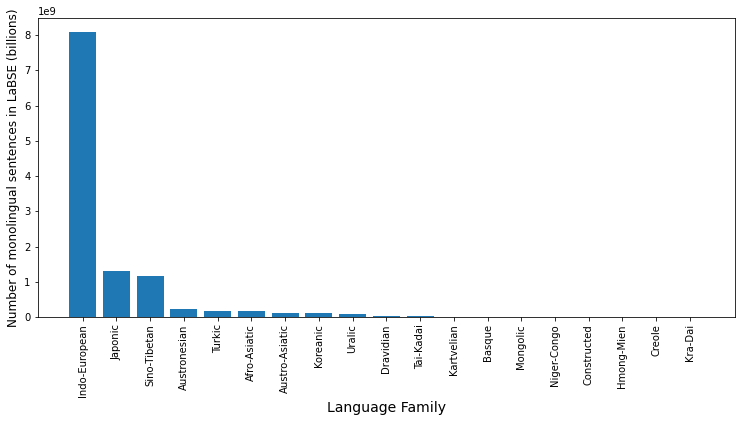

In [ ]:
fam_train_mono = {k: v for k, v in sorted(fam_train_mono.items(), key=lambda item: item[1], reverse=True)}
plt.bar(*zip(*fam_train_mono.items()))
plt.xticks(rotation = 90)
plt.xlabel('Language Family', fontsize=14)
plt.ylabel('Number of monolingual sentences in LaBSE (billions)', fontsize=12)
fig = plt.gcf()
fig.set_size_inches(12.5, 5.5)
plt.show()

In [ ]:
gen_train_mono, gen_train_align = {}, {}
for i in range(len(labse_train_df)):
    gen = labse_train_df.Genus[i] if type(labse_train_df.Genus[i])==str else labse_train_df.Family[i]
    
    if gen not in gen_train_mono: gen_train_mono[gen] = labse_train_df['Monolingual Sentences'][i]
    else: gen_train_mono[gen] += labse_train_df['Monolingual Sentences'][i]
    
    if gen not in gen_train_align: gen_train_align[gen] = labse_train_df['English-aligned sentences'][i]
    else: gen_train_align[gen] += labse_train_df['English-aligned sentences'][i]

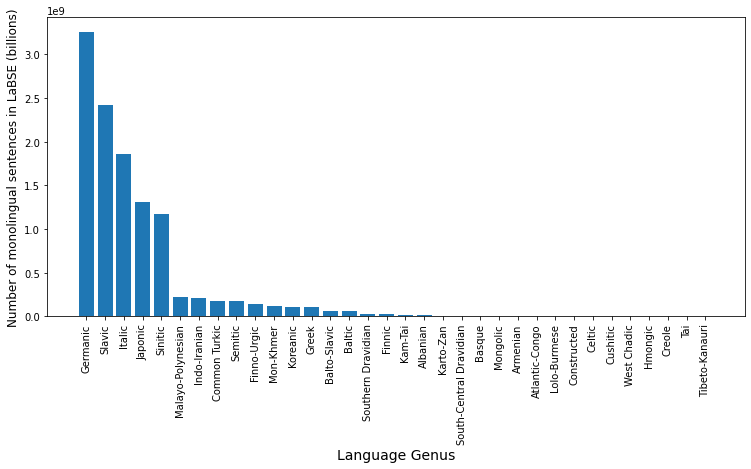

In [ ]:
gen_train_mono = {k: v for k, v in sorted(gen_train_mono.items(), key=lambda item: item[1], reverse=True)}
plt.bar(*zip(*gen_train_mono.items()))
plt.xticks(rotation = 90)
plt.xlabel('Language Genus', fontsize=14)
plt.ylabel('Number of monolingual sentences in LaBSE (billions)', fontsize=12)
fig = plt.gcf()
fig.set_size_inches(12.5, 5.5)
plt.show()

In [ ]:
fam_train_mono_by_lang = [fam_train_mono[fam_dict[lang]] for lang in labse_train_df.Language]
fam_train_align_by_lang = [fam_train_align[fam_dict[lang]] for lang in labse_train_df.Language]

gen_train_mono_by_lang = [gen_train_mono[genus_dict[lang]] for lang in labse_train_df.Language]
gen_train_align_by_lang = [gen_train_align[genus_dict[lang]] for lang in labse_train_df.Language]

In [ ]:
labse_train_df['In-family monolingual sentences'] = fam_train_mono_by_lang
labse_train_df['In-family English-aligned sentences'] = fam_train_align_by_lang
labse_train_df['In-genus monolingual sentences'] = gen_train_mono_by_lang
labse_train_df['In-genus English-aligned sentences'] = gen_train_align_by_lang

In [ ]:
labse_train_df.to_csv('Data/labse_train_stats_updated.csv')

### Updating language df with LaBSE train data

In [ ]:
# Re-load the dataframes if starting with a fresh kernel
lang_df = pd.read_csv('Data/bible_vars_LANGUAGE 12.csv')
labse_train_df = pd.read_csv('Data/labse_train_stats_updated 3.csv')

First, addressing individual languages

In [ ]:
# These are languages which appear to be in the Bible corpus but not in the 
# LaBSE train data, but are actually just denoted differently in each dataset
fake_diffs = {'Myanmar (Burmese)':'Burmese', 'Chinese (tokenised)':'Chinese', 
              'English (WEB translation)':'English', 'Farsi (Persian)':'Farsi', 
              'Japanese (tokenised)':'Japanese', 'Slovene':'Slovenian', 
              'Thai (tokenised)':'Thai', 'Ukranian':'Ukrainian', 
              'Vietnamese (tokenised)':'Vietnamese'}

In [ ]:
train_by_lang = {l:d for l,d in 
                      zip(labse_train_df.Language, labse_train_df['Total sentences'])}

In [ ]:
'''
[dict] bible_labse_train_lang
keys: languages in Bible corpus
values: monolingual train data for LaBSE for that language
'''
bible_labse_train_lang = {}
for lang in lang_df.Language:
    if lang in train_by_lang: 
        bible_labse_train_lang[lang] = train_by_lang[lang]
    elif lang in fake_diffs:
        bible_labse_train_lang[lang] = train_by_lang[fake_diffs[lang]]
    else:
        bible_labse_train_lang[lang] = 0

Next, addressing language families

In [ ]:
# Sorting out some minor discrepancies between the two dataframes
fake_diffs_fam = {'Altaic':'Turkic', 'Altaic(?)':'Koreanic'}

In [ ]:
train_by_fam = {f:d for f,d in 
                zip(labse_train_df.Family, labse_train_df['Total in-family sentences'])}

In [ ]:
bible_labse_train_fam = {}
for lang in lang_df.Language:
    if lang in fam_dict:
        fam = fam_dict[lang]
    elif lang in fake_diffs:
        fam = fam_dict[fake_diffs[lang]]
    else:
        fam = None # :(
    bible_labse_train_fam[lang] = train_by_fam[fam] if fam else 0

Finally, addressing language genuses

In [ ]:
# Once again, dealing with discrepancies
fake_diffs_gen = {'Finno-Ugric':'Finno-Urgic', 'South-Central':'South-Central Dravidian',
                  'Southern':'Southern Dravidian', 'Turkic':'Common Turkic'}

In [ ]:
train_by_gen = {g:d for g,d in 
                zip(labse_train_df.Genus, labse_train_df['Total in-genus sentences'])}

In [ ]:
bible_labse_train_gen = {}
for lang in lang_df.Language:
    if lang in genus_dict:
        gen = genus_dict[lang]
    elif lang in fake_diffs:
        gen = genus_dict[fake_diffs[lang]]
    else:
        gen = None # :(
    
    if gen=='Constructed': gen = 'Esperanto'
    if gen=='Creole': gen = 'Haitian Creole'
    bible_labse_train_gen[lang] = train_by_gen[gen] if gen else 0

In [ ]:
pd.DataFrame({'Total sentences (LaBSE)':list(bible_labse_train_lang.values()),
              'Total in-family sentences (LaBSE)':list(bible_labse_train_fam.values()),
              'Total in-genus sentences (LaBSE)':list(bible_labse_train_gen.values())}).to_csv('Data/bible_labse_train_lang.csv')

### Updating language df with LASER train data

Individual languages

In [ ]:
laser_train_df = pd.read_csv('Data/LASER_training_stats 2.csv')

In [ ]:
las_train_by_lang = {l:d for l,d in zip(laser_train_df.Language, laser_train_df['Parallel sentences'])}

In [ ]:
fake_diffs2 = {'Chinese (tokenised)':'Chinese', 'English (WEB translation)':'English',
               'Japanese (tokenised)':'Japanese', 'Myanmar (Burmese)':'Burmese',
               'Norwegian':'Norwegian Bokmål', 'Slovene':'Slovenian', 'Thai (tokenised)':'Thai', 
               'Ukranian':'Ukrainian', 'Vietnamese (tokenised)':'Vietnamese'}

In [ ]:
bible_laser_train_lang = {}
for lang in lang_df.Language:
    if lang in las_train_by_lang: 
        bible_laser_train_lang[lang] = las_train_by_lang[lang]
    elif lang in fake_diffs2:
        bible_laser_train_lang[lang] = las_train_by_lang[fake_diffs2[lang]]
    else:
        bible_laser_train_lang[lang] = 0

Language families

In [ ]:
laser_lang_to_fam = {}
for i in range(len(laser_train_df)):
    lang = laser_train_df.Language[i]
    fam = laser_train_df.Family[i]
    if laser_train_df.Family.isna()[i]: # if the family is missing
        laser_lang_to_fam[lang] = fam_dict[lang]
    else:
        laser_lang_to_fam[lang] = fam

In [ ]:
las_train_by_fam = {}
for i in range(len(laser_train_df)):
    lang = laser_train_df.Language[i]
    fam = laser_lang_to_fam[lang]
    if fam not in las_train_by_fam:
        las_train_by_fam[fam] = laser_train_df['Parallel sentences'][i]
    else:
        las_train_by_fam[fam] += laser_train_df['Parallel sentences'][i]

In [ ]:
bible_laser_train_fam = {}
for lang in lang_df.Language:
    if lang in laser_lang_to_fam:
        fam = laser_lang_to_fam[lang]
    elif lang in fake_diffs2:
        fam = laser_lang_to_fam[fake_diffs2[lang]]
    else:
        fam = None # :(
    bible_laser_train_fam[lang] = las_train_by_fam[fam] if fam else 0

Language genuses

In [ ]:
laser_lang_to_gen = {}
for i in range(len(laser_train_df)):
    lang = laser_train_df.Language[i]
    gen = laser_train_df.Genus[i]
    if laser_train_df.Family.isna()[i]: # if the genus is missing
        laser_lang_to_gen[lang] = genus_dict[lang]
    else:
        laser_lang_to_gen[lang] = gen

In [ ]:
las_train_by_gen = {}
for i in range(len(laser_train_df)):
    lang = laser_train_df.Language[i]
    gen = laser_lang_to_gen[lang]
    if gen not in las_train_by_gen:
        las_train_by_gen[gen] = laser_train_df['Parallel sentences'][i]
    else:
        las_train_by_gen[gen] += laser_train_df['Parallel sentences'][i]

In [ ]:
bible_laser_train_gen = {}
for lang in lang_df.Language:
    if lang in laser_lang_to_gen:
        gen = laser_lang_to_gen[lang]
    elif lang in fake_diffs2:
        gen = laser_lang_to_gen[fake_diffs2[lang]]
    else:
        gen = None # :(
    bible_laser_train_gen[lang] = las_train_by_gen[gen] if gen else 0

In [ ]:
pd.DataFrame({'Total sentences (LASER)':list(bible_laser_train_lang.values()),
              'Total in-family sentences (LASER)':list(bible_laser_train_fam.values()),
              'Total in-genus sentences (LASER)':list(bible_laser_train_gen.values())}).to_csv('Data/bible_laser_train_lang.csv')

### Applying train data info to language pairs

In [ ]:
# Load the newest language dataframe with all the training stats
lang_df = pd.read_csv('Data/bible_vars_LANGUAGE 14.csv')

In [ ]:
# We need to create a dict mapping languages to their associated training data statistics
# As done before, we need to deal with some minor discrepancies in the data files first
ldf_langs = list(lang_df.Language)
for i in range(len(ldf_langs)):
    if ldf_langs[i]=='Haitian Creole': ldf_langs[i]='Creole'
for i in range(len(ldf_langs)):
    if ldf_langs[i]!=sorted(langs)[i]:
        ldf_langs[i] = sorted(langs)[i]

In [ ]:
train_lang_labse = list(lang_df['Total sentences (LaBSE)'])
# Index of Haitian Creole
train_lang_labse.pop(38)
cr_idx = ldf_langs.index('Creole')
train_lang_labse.insert(cr_idx, 70091000) # Number of train sentences for LaBSE
train_lang_labse_dict = {l:d for l,d in zip(ldf_langs, train_lang_labse)}

In [ ]:
combined_train_lang_labse = []
for l1,l2 in itertools.combinations(langs, 2):
    l1_train_lang_labse = train_lang_labse_dict[l1]
    l2_train_lang_labse = train_lang_labse_dict[l2]
    combined_train_lang_labse.append(l1_train_lang_labse+l2_train_lang_labse)

In [ ]:
def langDataToLangPair(langs: list, lang_df:pd.DataFrame, data_component: str) -> list:
    POP_IDX = 38
    HCR_IDX = list(lang_df.Language).index('Haitian Creole')
    INSERT = lang_df[data_component][HCR_IDX]
    
    ldf_langs = list(lang_df.Language)
    for i in range(len(ldf_langs)):
        if ldf_langs[i]=='Haitian Creole': ldf_langs[i]='Creole'
    for i in range(len(ldf_langs)):
        if ldf_langs[i]!=sorted(langs)[i]:
            ldf_langs[i] = sorted(langs)[i]
    
    train_data = list(lang_df[data_component])
    # Index of Haitian Creole
    train_data.pop(POP_IDX)
    cr_idx = ldf_langs.index('Creole')
    train_data.insert(cr_idx, INSERT)
    train_data = {l:d for l,d in zip(ldf_langs, train_data)}
    
    combined_train_data = []
    for l1,l2 in itertools.combinations(langs, 2):
        l1_train = train_data[l1]
        l2_train = train_data[l2]
        combined_train_data.append(l1_train+l2_train)
    
    return combined_train_data

In [ ]:
combined_train_lang_labse = langDataToLangPair(langs, lang_df, 'Total sentences (LaBSE)')
combined_train_fam_labse = langDataToLangPair(langs, lang_df, 'Total in-family sentences (LaBSE)')
combined_train_gen_labse = langDataToLangPair(langs, lang_df, 'Total in-genus sentences (LaBSE)')

combined_train_lang_laser = langDataToLangPair(langs, lang_df, 'Total sentences (LASER)')
combined_train_fam_laser = langDataToLangPair(langs, lang_df, 'Total in-family sentences (LASER)')
combined_train_gen_laser = langDataToLangPair(langs, lang_df, 'Total in-genus sentences (LASER)')

In [ ]:
pd.DataFrame({'Combined sentences (LaBSE)':combined_train_lang_labse,
              'Combined in-family sentences (LaBSE)':combined_train_fam_labse,
              'Combined in-genus sentences (LaBSE)':combined_train_gen_labse,
              'Combined sentences (LASER)':combined_train_lang_laser,
              'Combined in-family sentences (LASER)':combined_train_fam_laser,
              'Combined in-genus sentences (LASER)':combined_train_gen_laser}).to_csv('Data/lang_pair_train.csv')